In [32]:
import heist
import helpers
import torch.distributions
import torch

import gym
import random
import numpy as np
from helpers import generate_action, load_model
from procgen import ProcgenGym3Env
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_modified import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv

%load_ext autoreload
%autoreload 2

In [2]:

env_name = "procgen:procgen-heist-v0"  

env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 

model = load_model()

In [3]:
class ModelActivations:
    def __init__(self, model):
        self.activations = {}
        self.model = model
        self.hooks = []  # To keep track of hooks

    def clear_hooks(self):
        # Remove all previously registered hooks
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.activations = {}

    def get_activation(self, name):
        def hook(model, input, output):
            processed_output = []
            for item in output:
                if isinstance(item, torch.Tensor):
                    processed_output.append(item.detach())
                elif isinstance(item, torch.distributions.Categorical):
                    processed_output.append(item.logits.detach())
                else:
                    processed_output.append(item)
            self.activations[name] = tuple(processed_output)
        return hook

    def register_hook_by_path(self, path, name):
        elements = path.split('.')
        model = self.model
        for i, element in enumerate(elements):
            if '[' in element:
                base, index = element.replace(']', '').split('[')
                index = int(index)
                model = getattr(model, base)[index]
            else:
                model = getattr(model, element)
            if i == len(elements) - 1:
                hook = model.register_forward_hook(self.get_activation(name))
                self.hooks.append(hook)  # Keep track of the hook

    def run_with_cache(self, input, layer_paths):
        self.clear_hooks()  # Clear any existing hooks
        self.activations = {}  # Reset activations
        for path in layer_paths:
            self.register_hook_by_path(path, path.replace('.', '_'))
        output = self.model(input)
        return output, self.activations



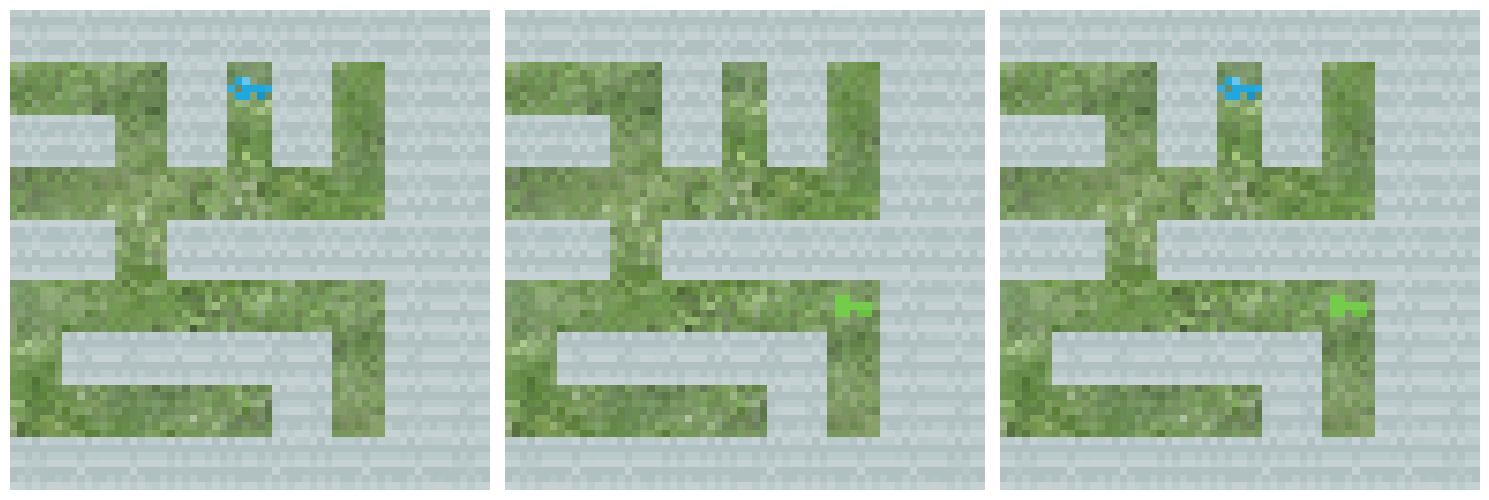

In [11]:
num_samples = 1
num_levels = 100
key_color_combinations = [['blue'], ['green'], ['blue', 'green']]
observations_list = heist.create_key_states(key_color_combinations, num_samples, num_levels)


import itertools
fig, axs = plt.subplots(1, 3, figsize=(15, 12))  # Adjusted to create a 5x3 grid
for ( j), obs in zip(itertools.product(range(3)), itertools.chain.from_iterable(observations_list)):
    axs[ j].imshow(obs.transpose(1, 2, 0))
    # axs[i, j].set_title(f"Sample {j+1}, Obs {i+1}")
    axs[j].axis('off')
plt.tight_layout()
plt.show()

In [12]:
observations_list[0][0].shape

(3, 64, 64)

In [52]:
layer_paths = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]

In [53]:
model_activations = ModelActivations(model)
model_activations.clear_hooks()
blue_key_only = observations_list[0][0]
blue_key_only =  blue_key_only.transpose(1,2,0)
green_key_only = observations_list[0][1].transpose(1,2,0)
blue_and_green_key = observations_list[0][2].transpose(1,2,0)

obs1 = torch.tensor(blue_key_only, dtype=torch.float32).unsqueeze(0)
obs2 = torch.tensor(blue_and_green_key, dtype=torch.float32).unsqueeze(0)

output1, blue_key_only_activations = model_activations.run_with_cache(obs1, layer_paths)
output2, blue_and_green_key_activations = model_activations.run_with_cache(obs2, layer_paths)



In [59]:
differences = helpers.compute_activation_differences(blue_and_green_key_activations,blue_key_only_activations)
layer_paths = differences.keys()
print(layer_paths)

helpers.plot_activations_for_layers(blue_and_green_key_activations, layer_paths)

torch.Size([16, 64, 64])
Key: conv_seqs_0_conv has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block0_conv0 has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block0_conv1 has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block1_conv0 has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block1_conv1 has non-zero differences.
torch.Size([32, 32, 32])
Key: conv_seqs_1_conv has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block0_conv0 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block0_conv1 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block1_conv0 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block1_conv1 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_2_conv has non-zero differences.
torch.Size([32, 8, 8])
Key: conv_seqs_2_res_block0_conv0 has non-zero differences.
torch.Size([32, 8,

AttributeError: 'tuple' object has no attribute 'cpu'

In [48]:
differences.keys()


dict_keys(['conv_seqs_0_conv', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_1_conv', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1'])

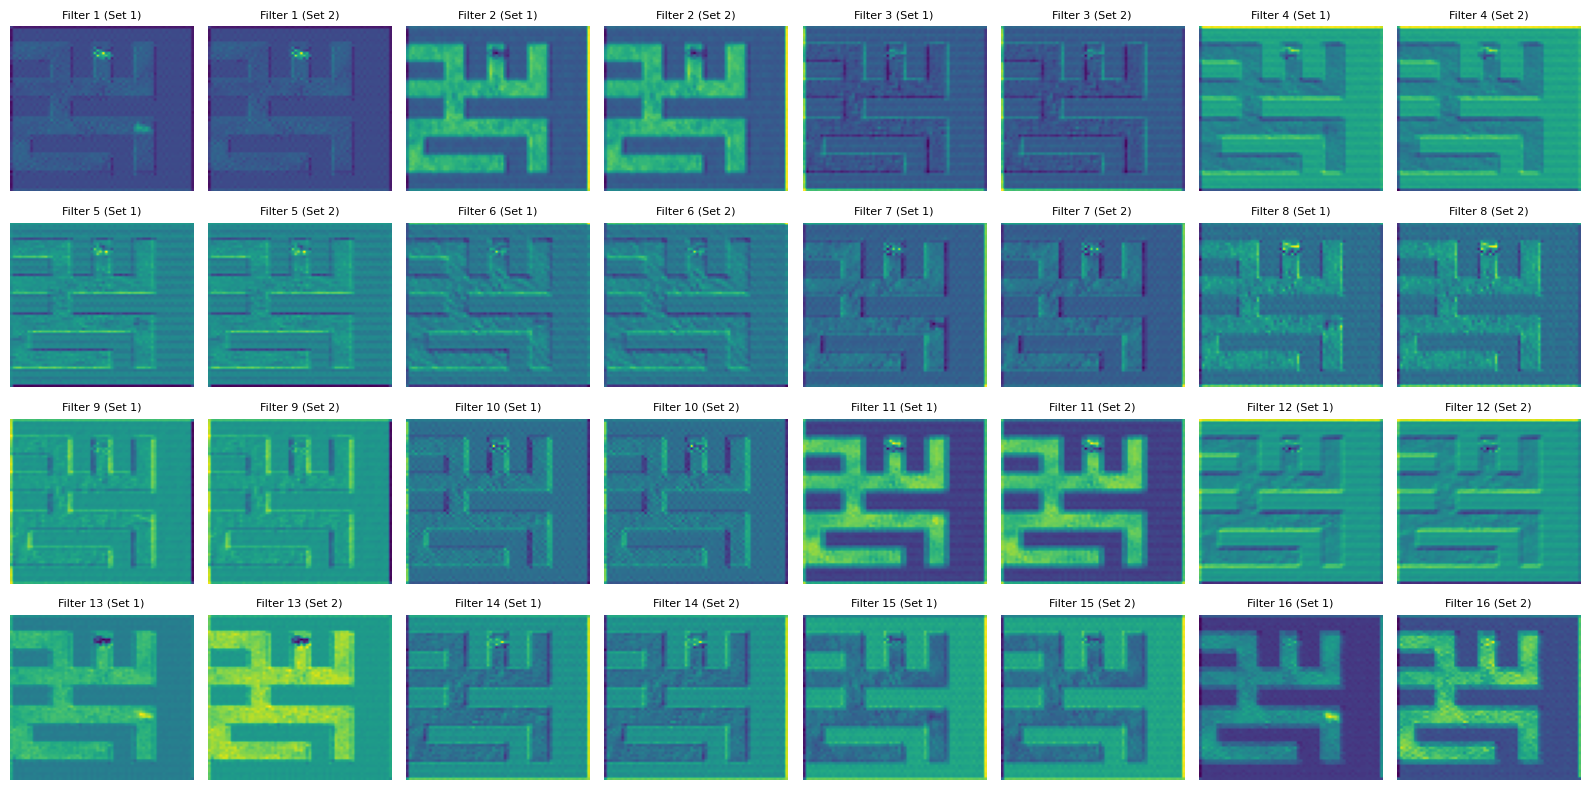

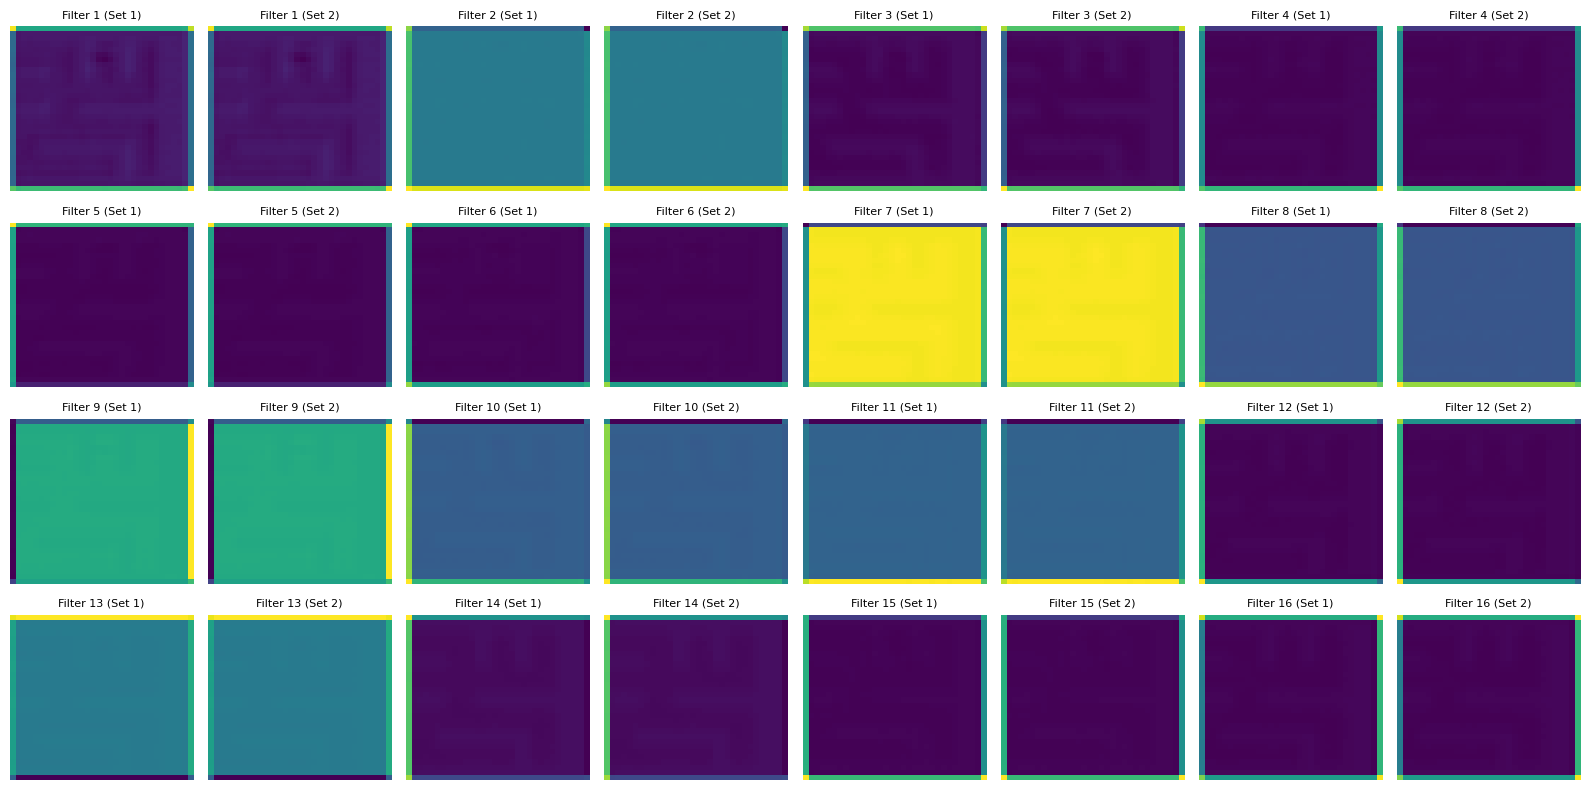

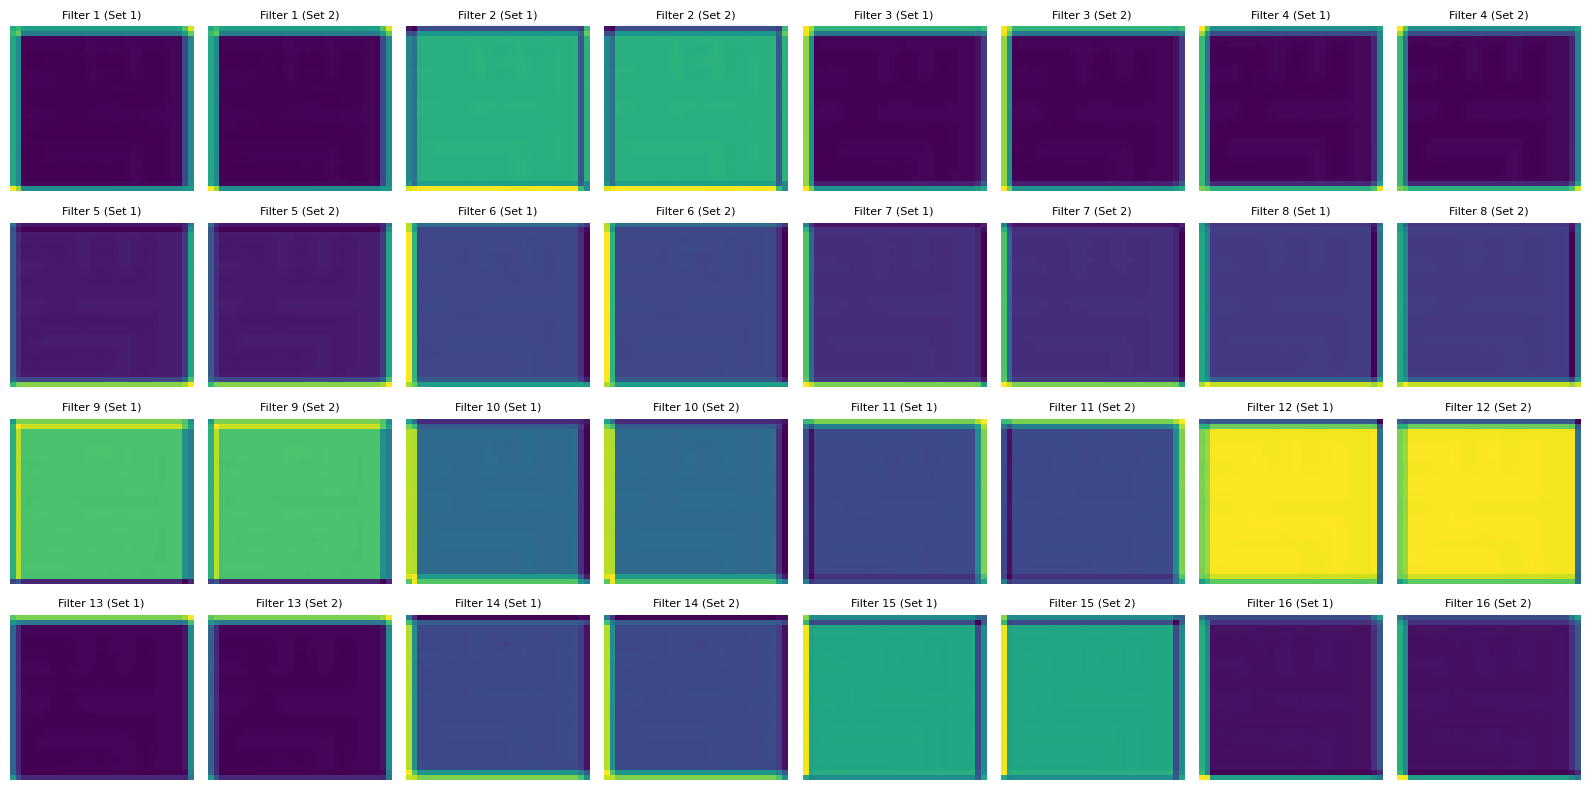

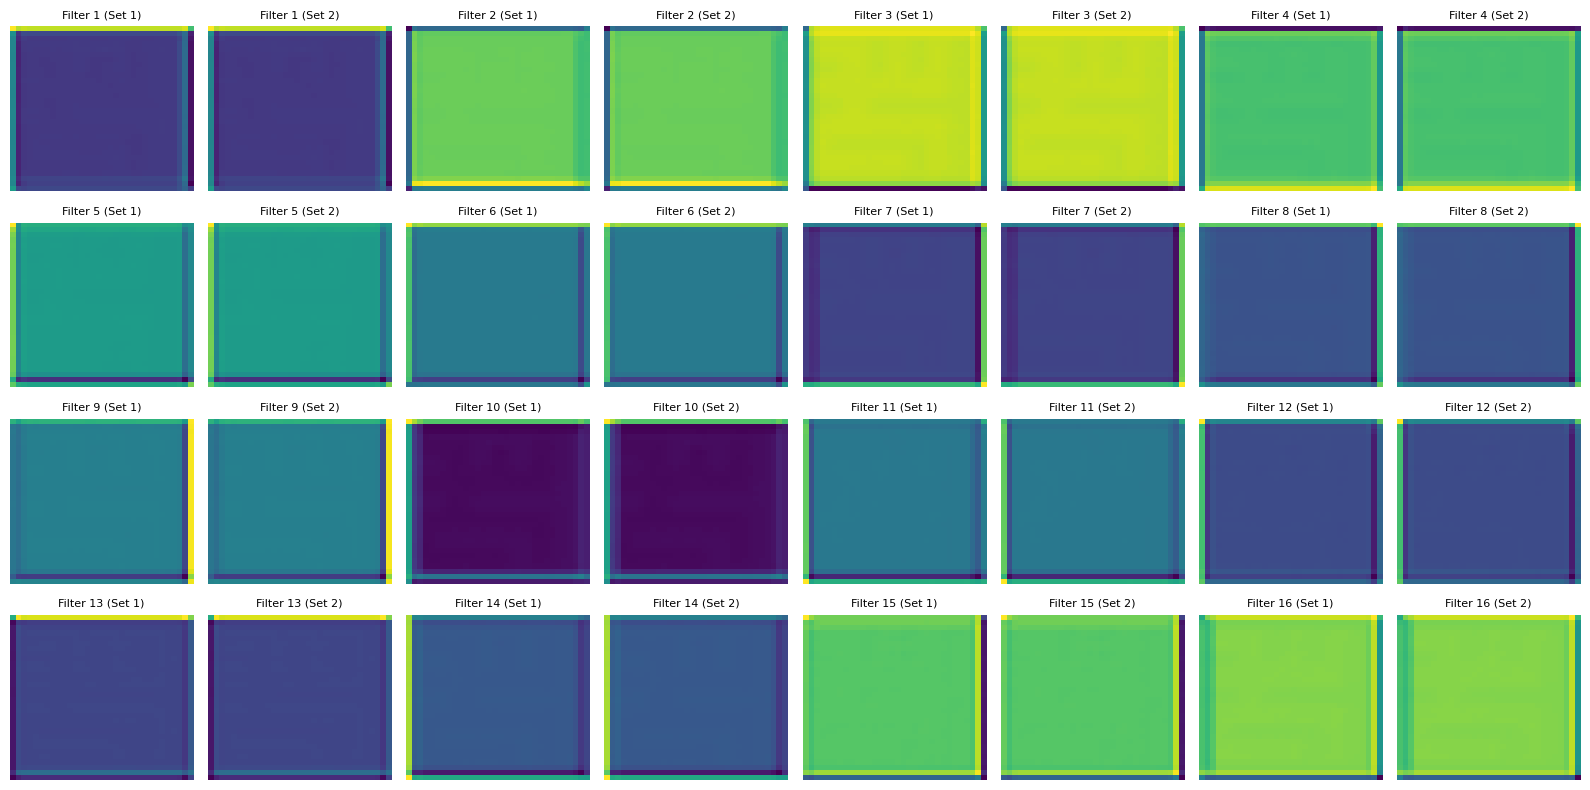

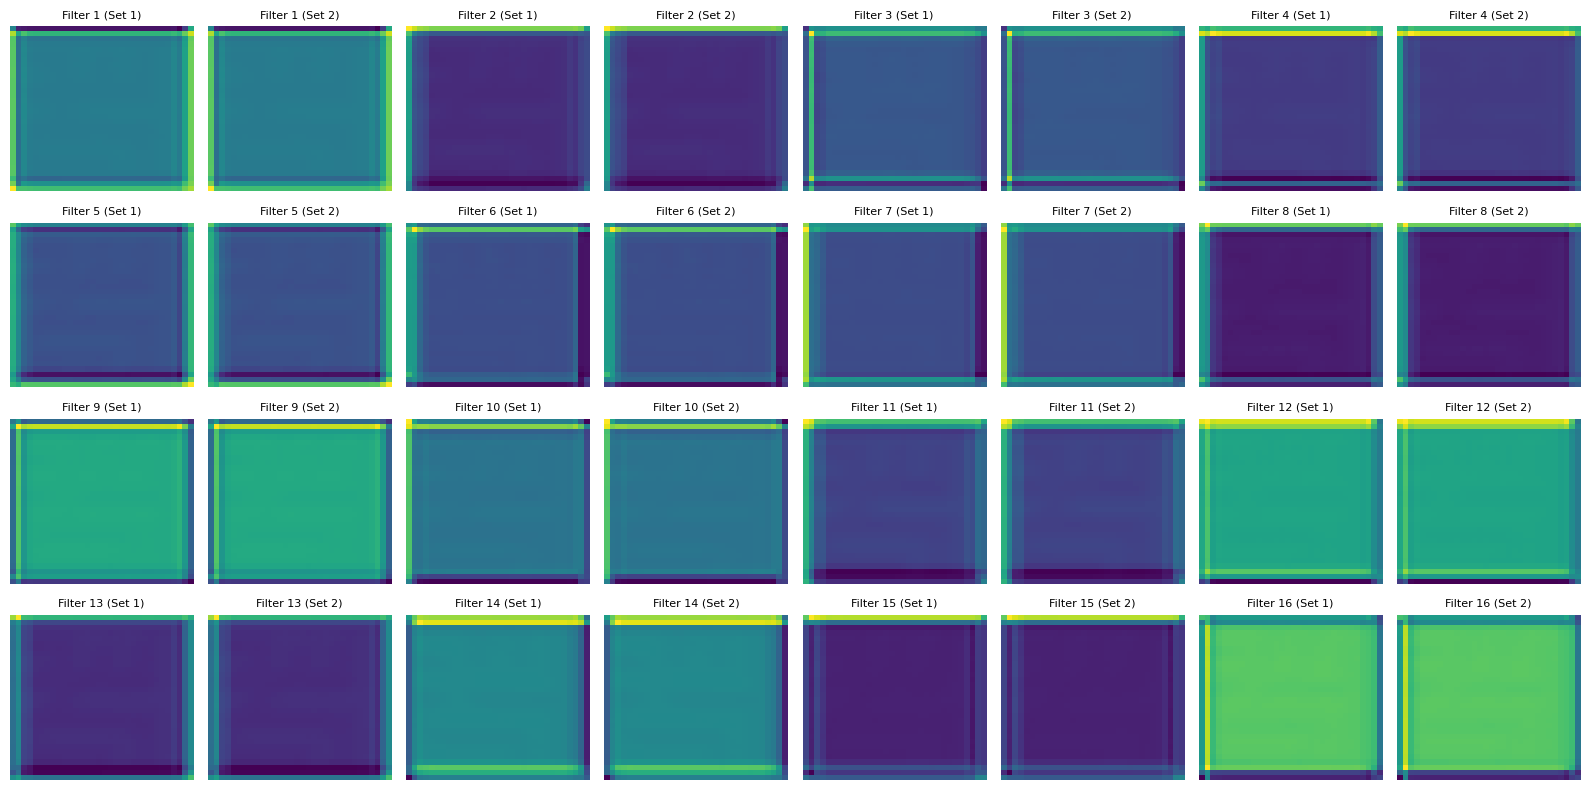

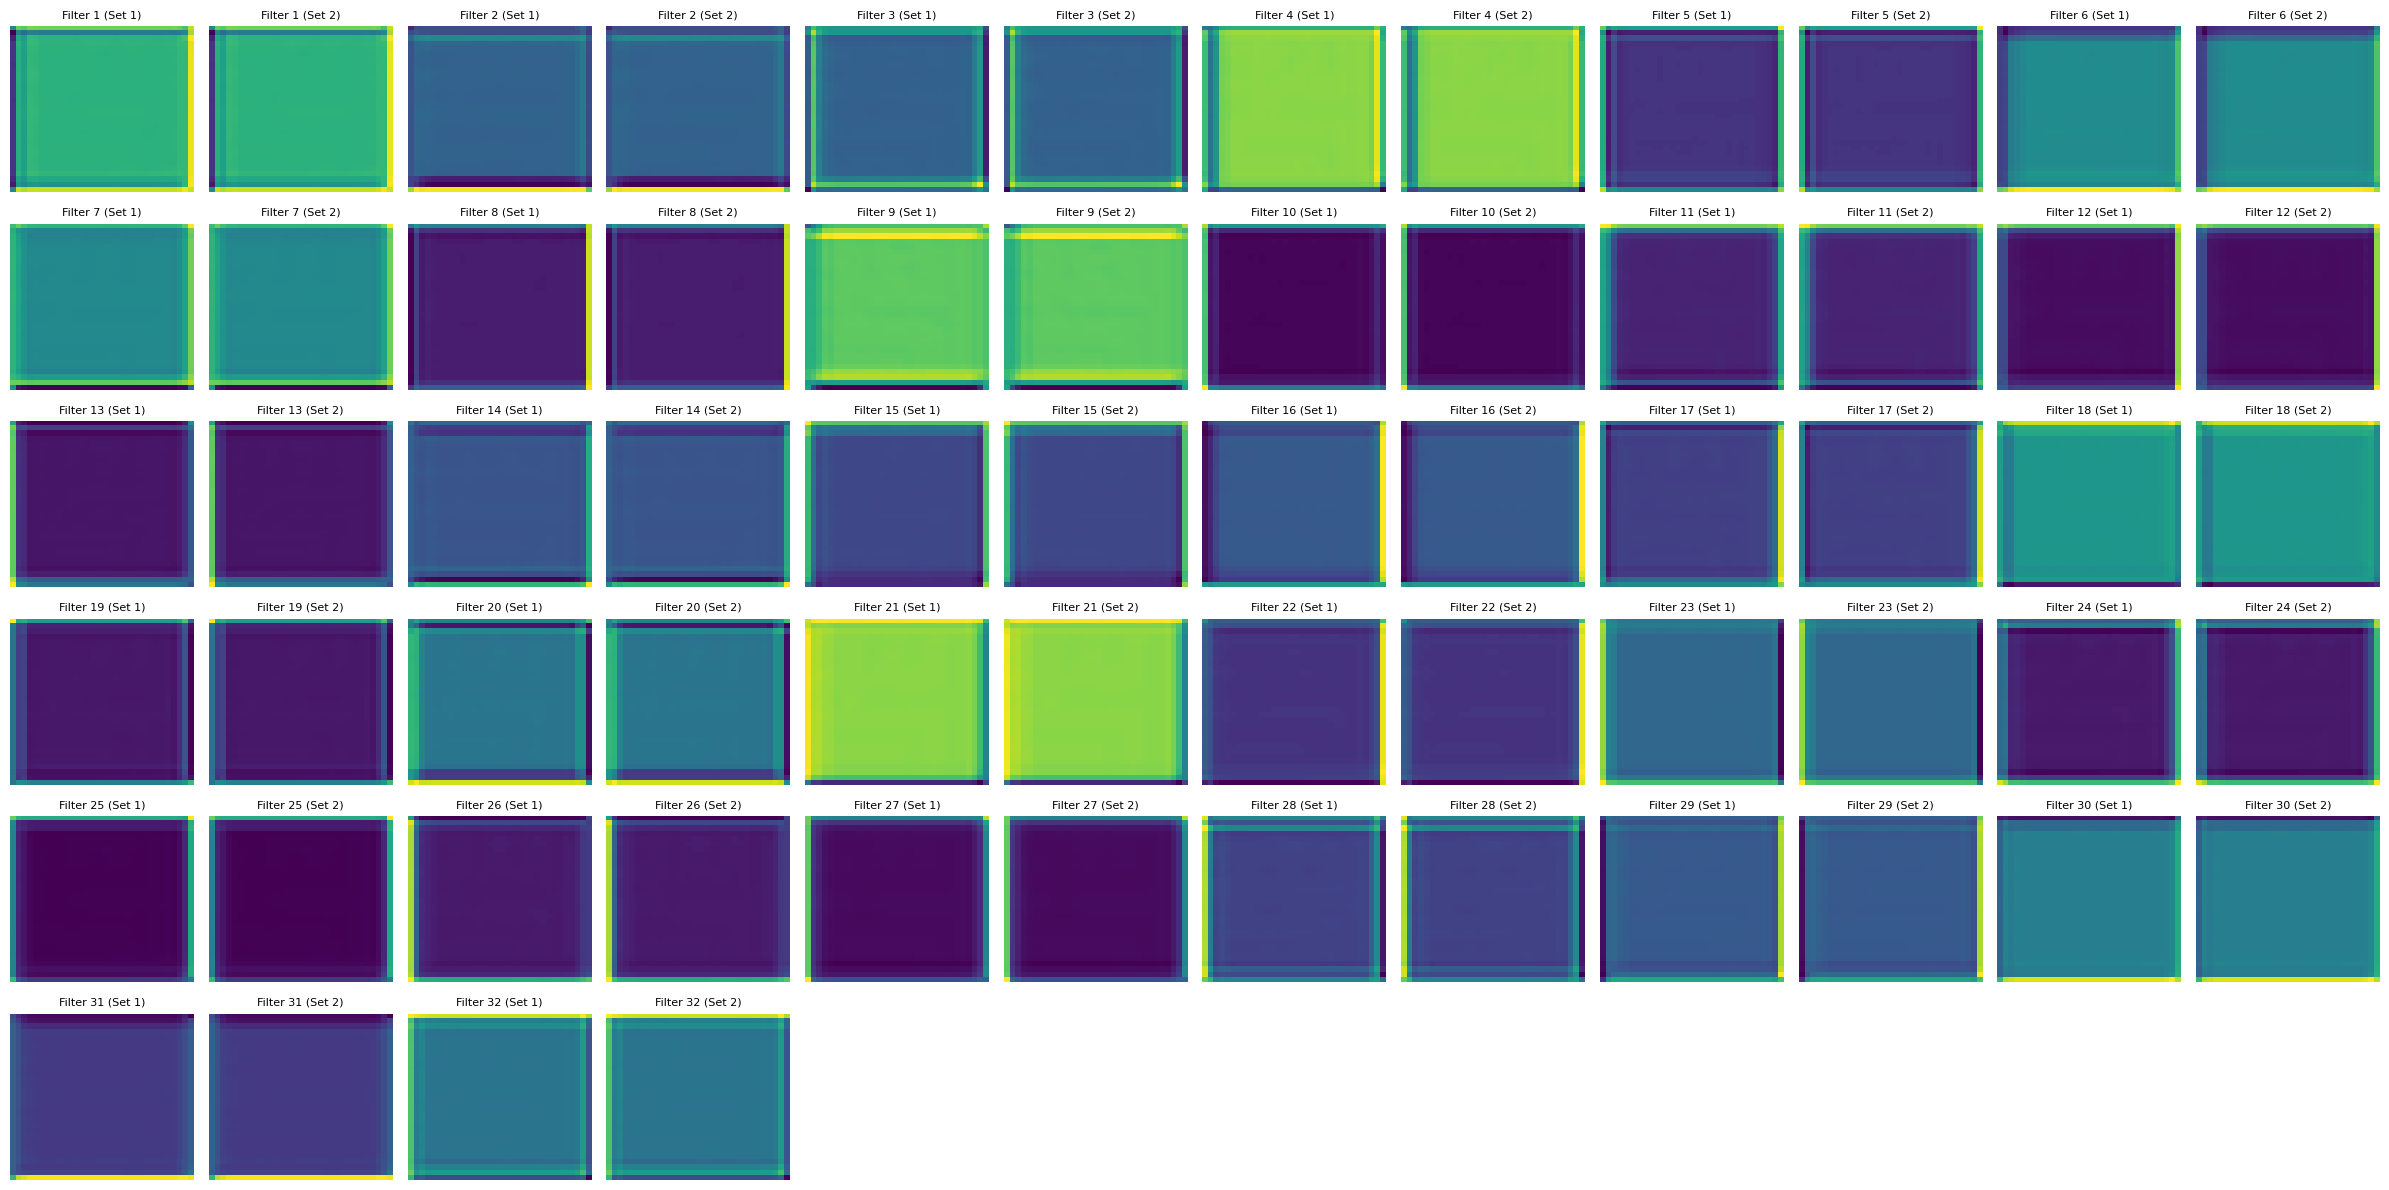

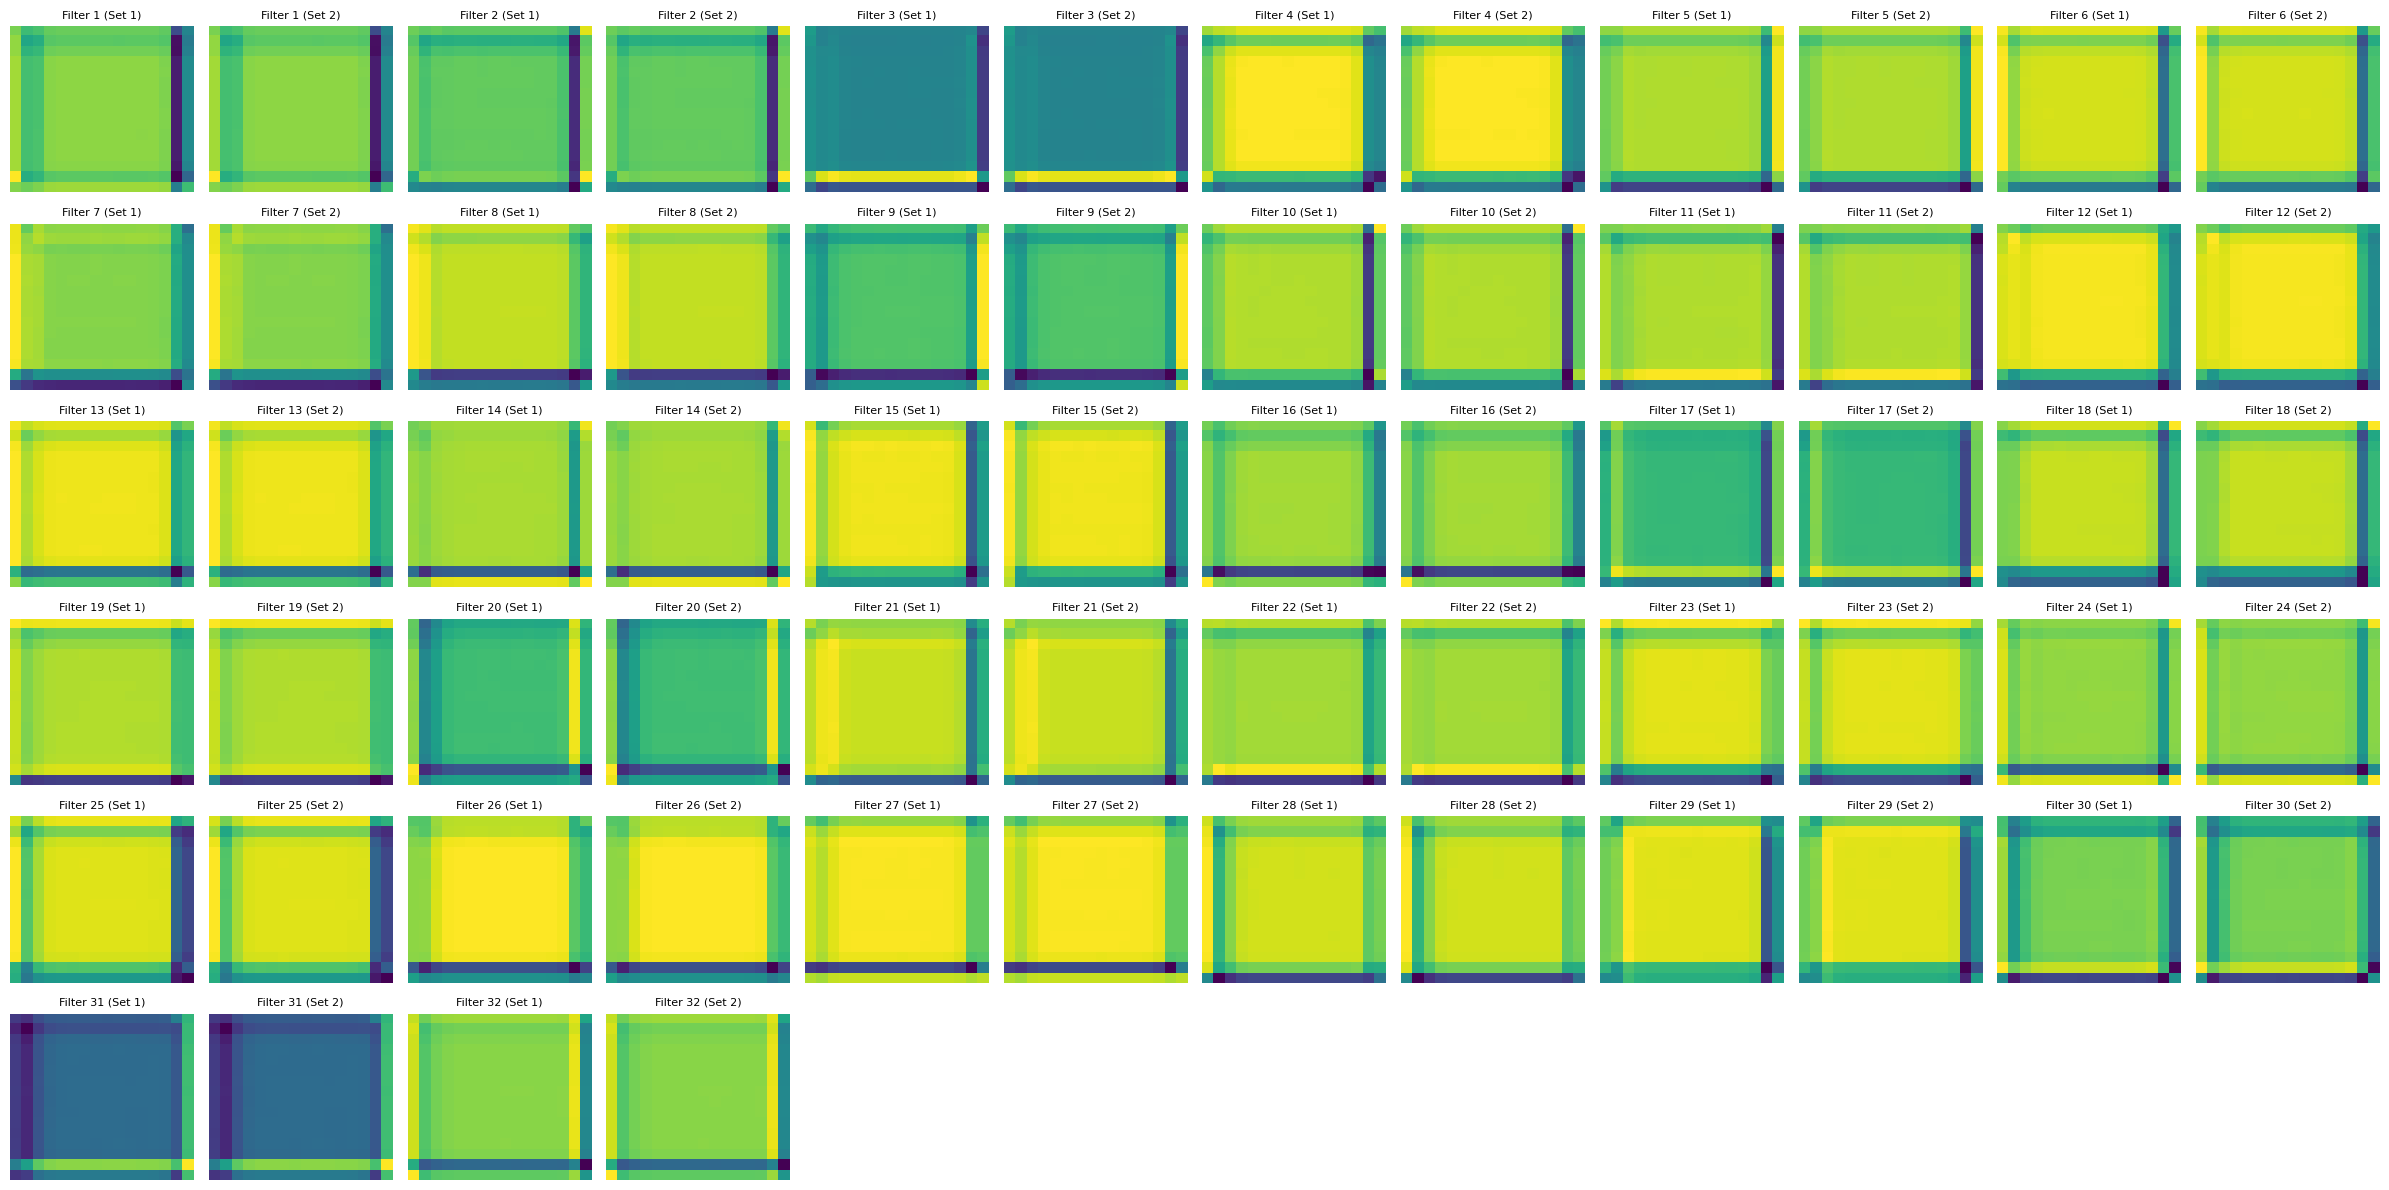

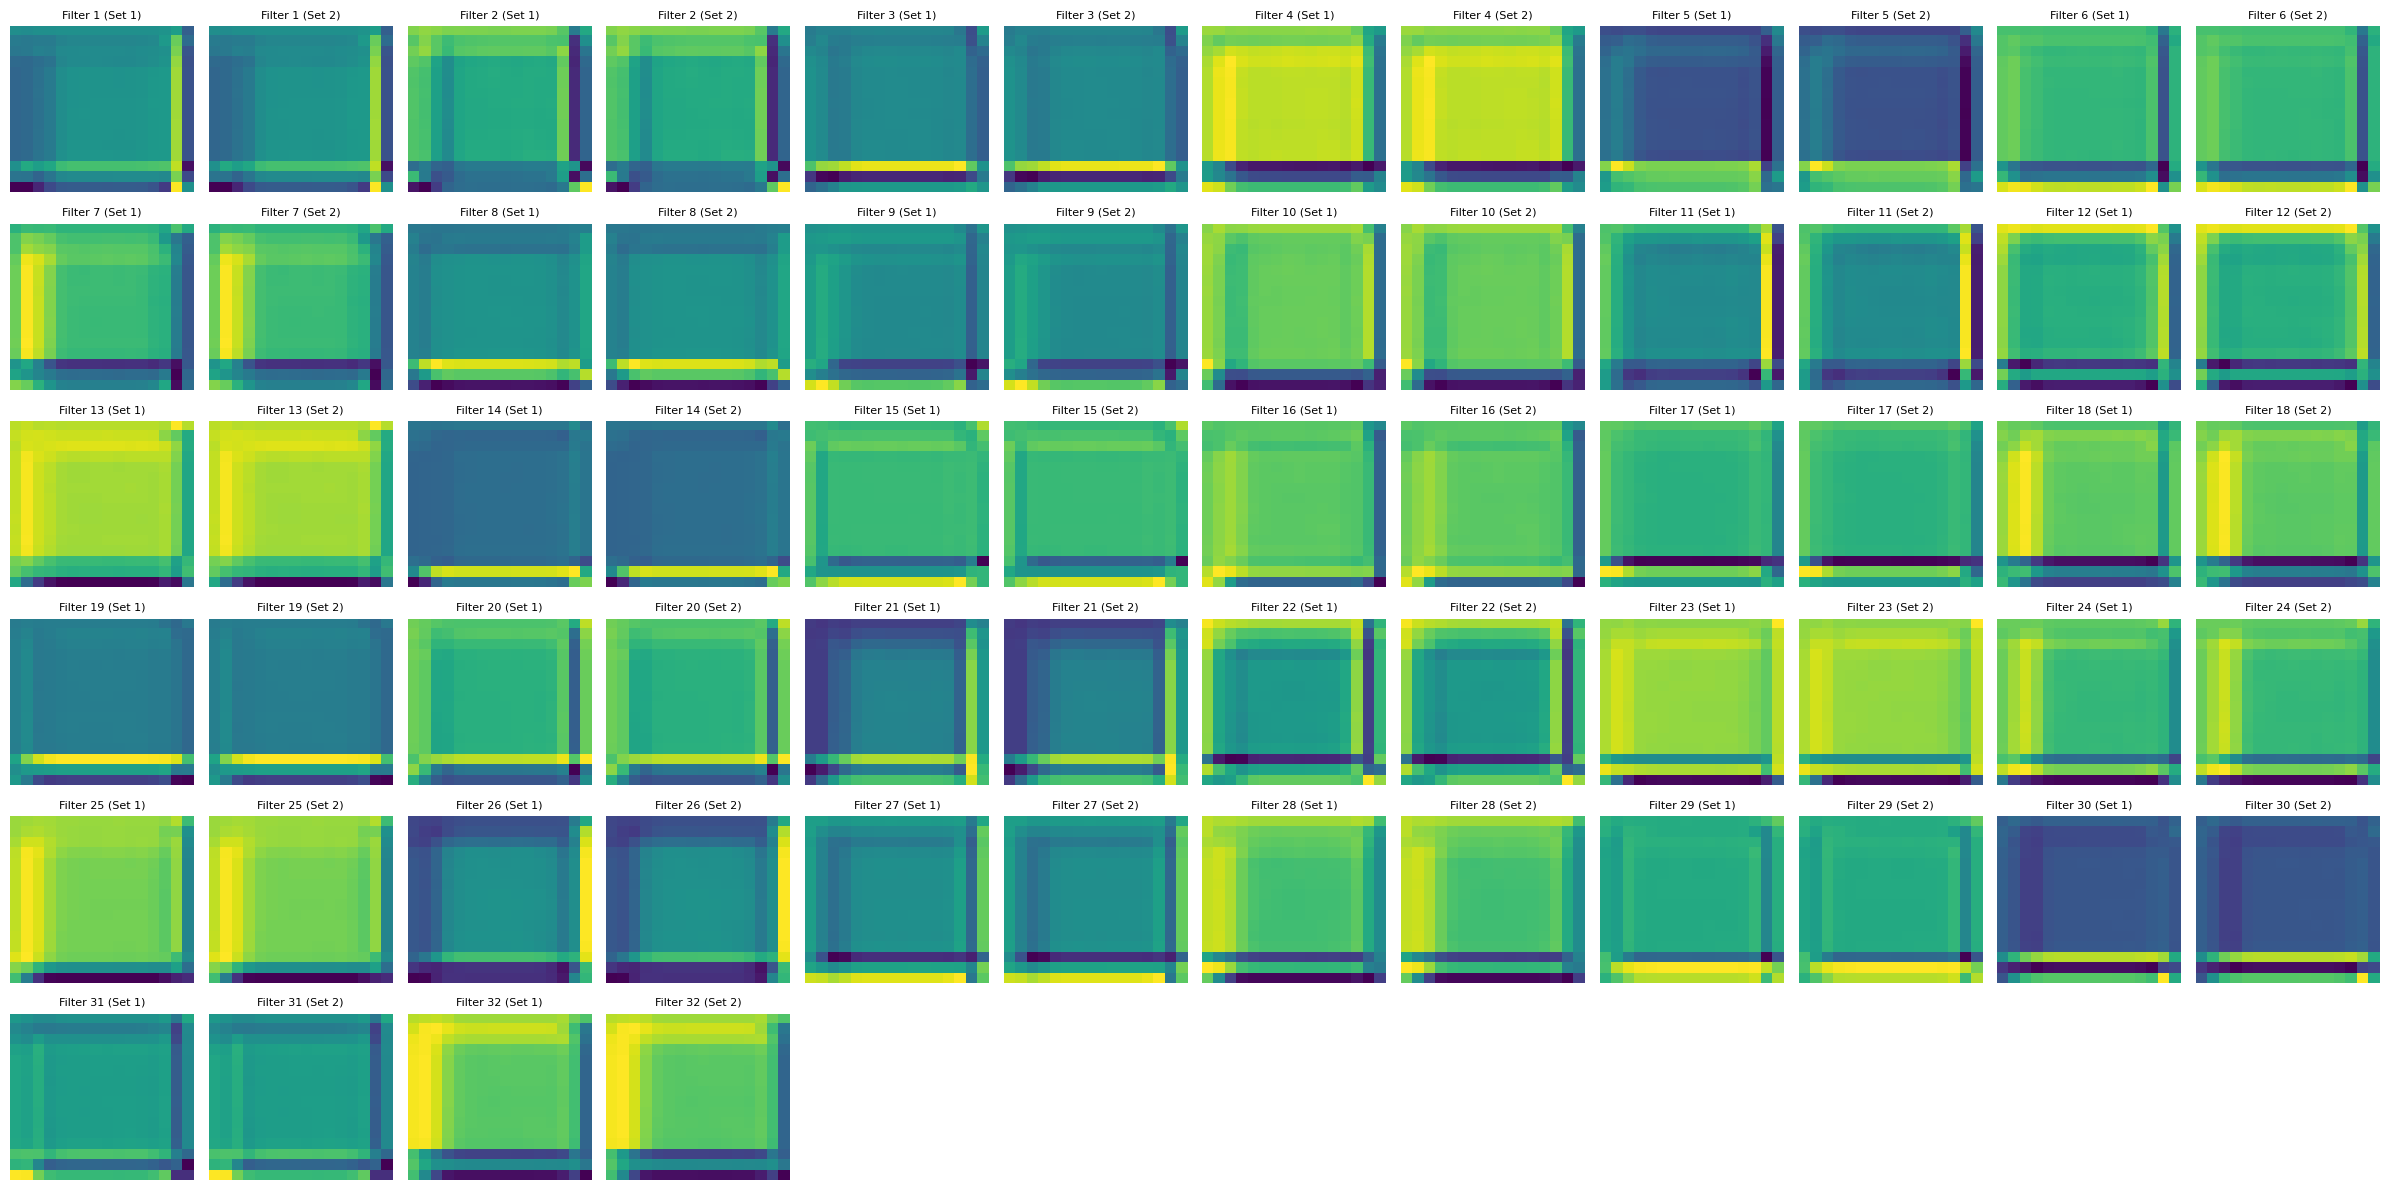

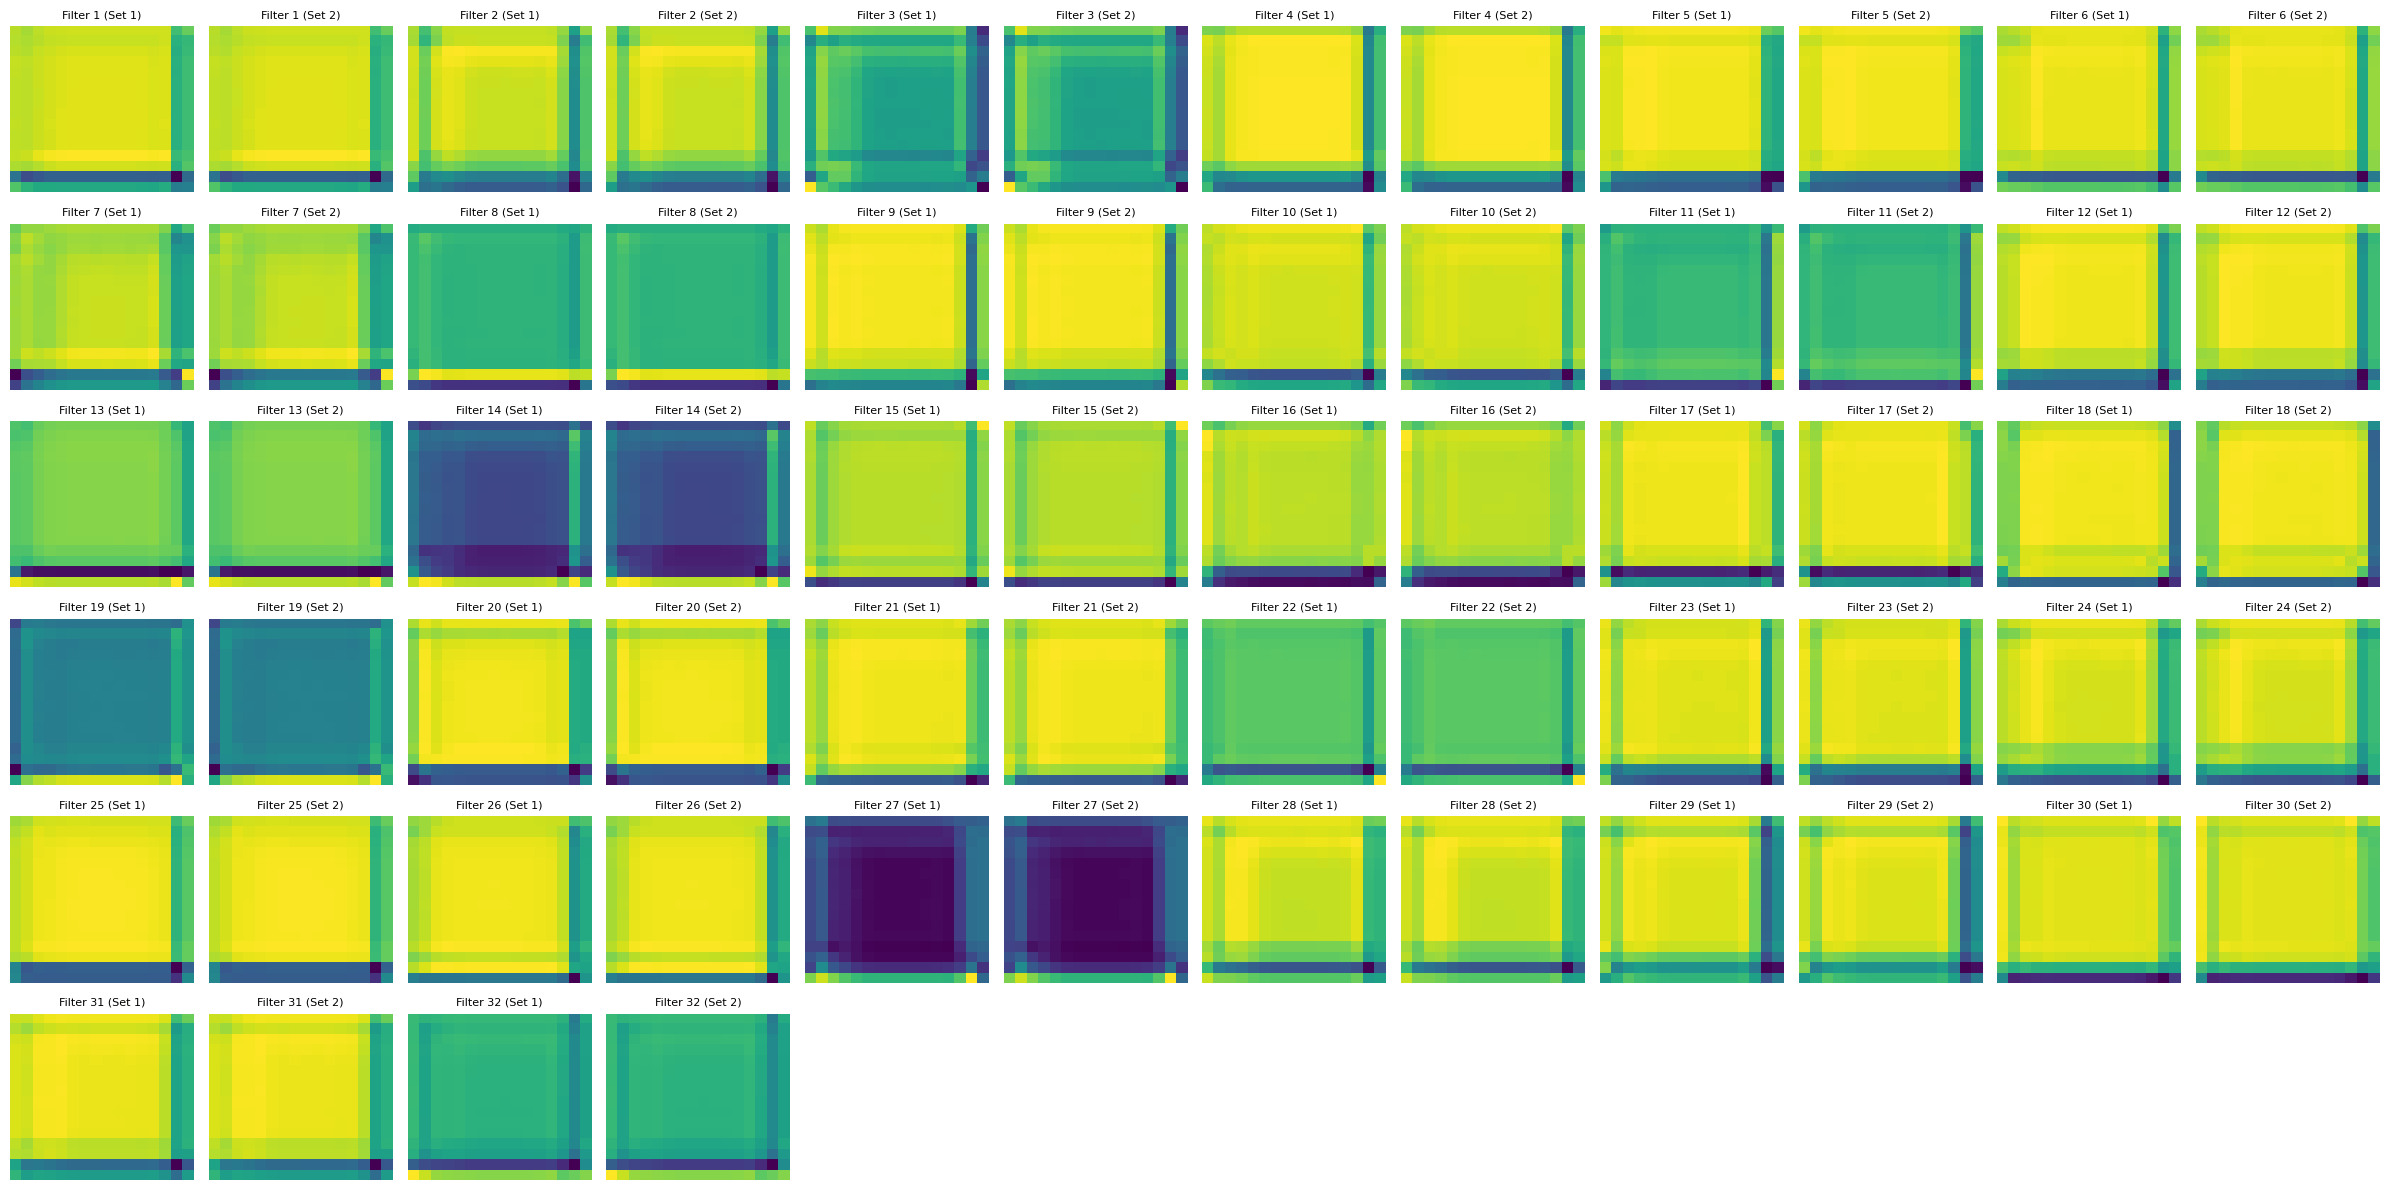

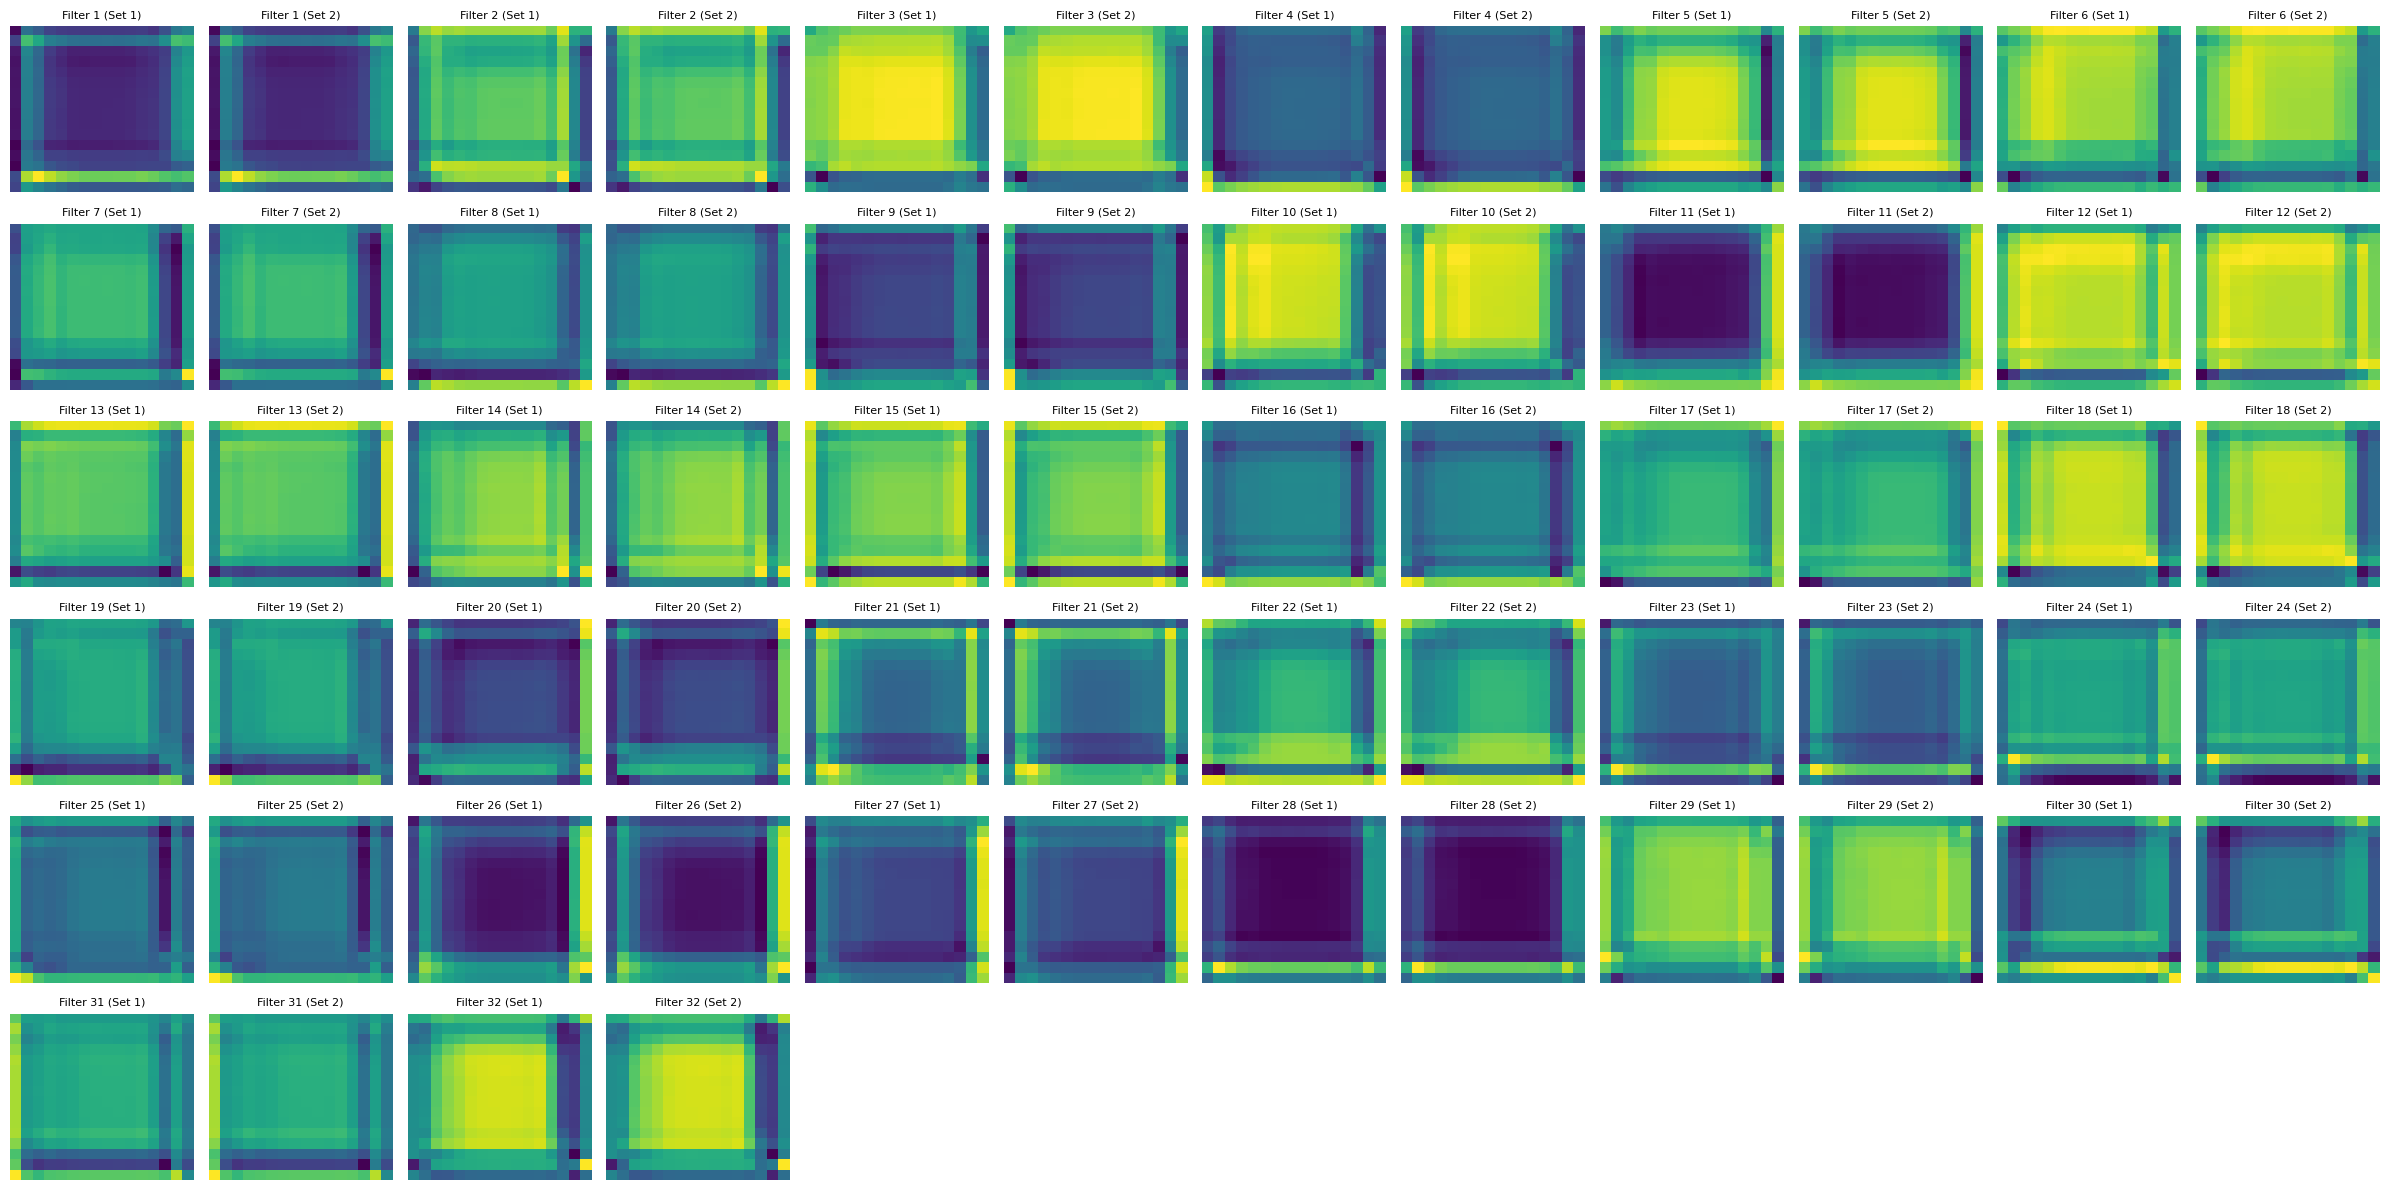

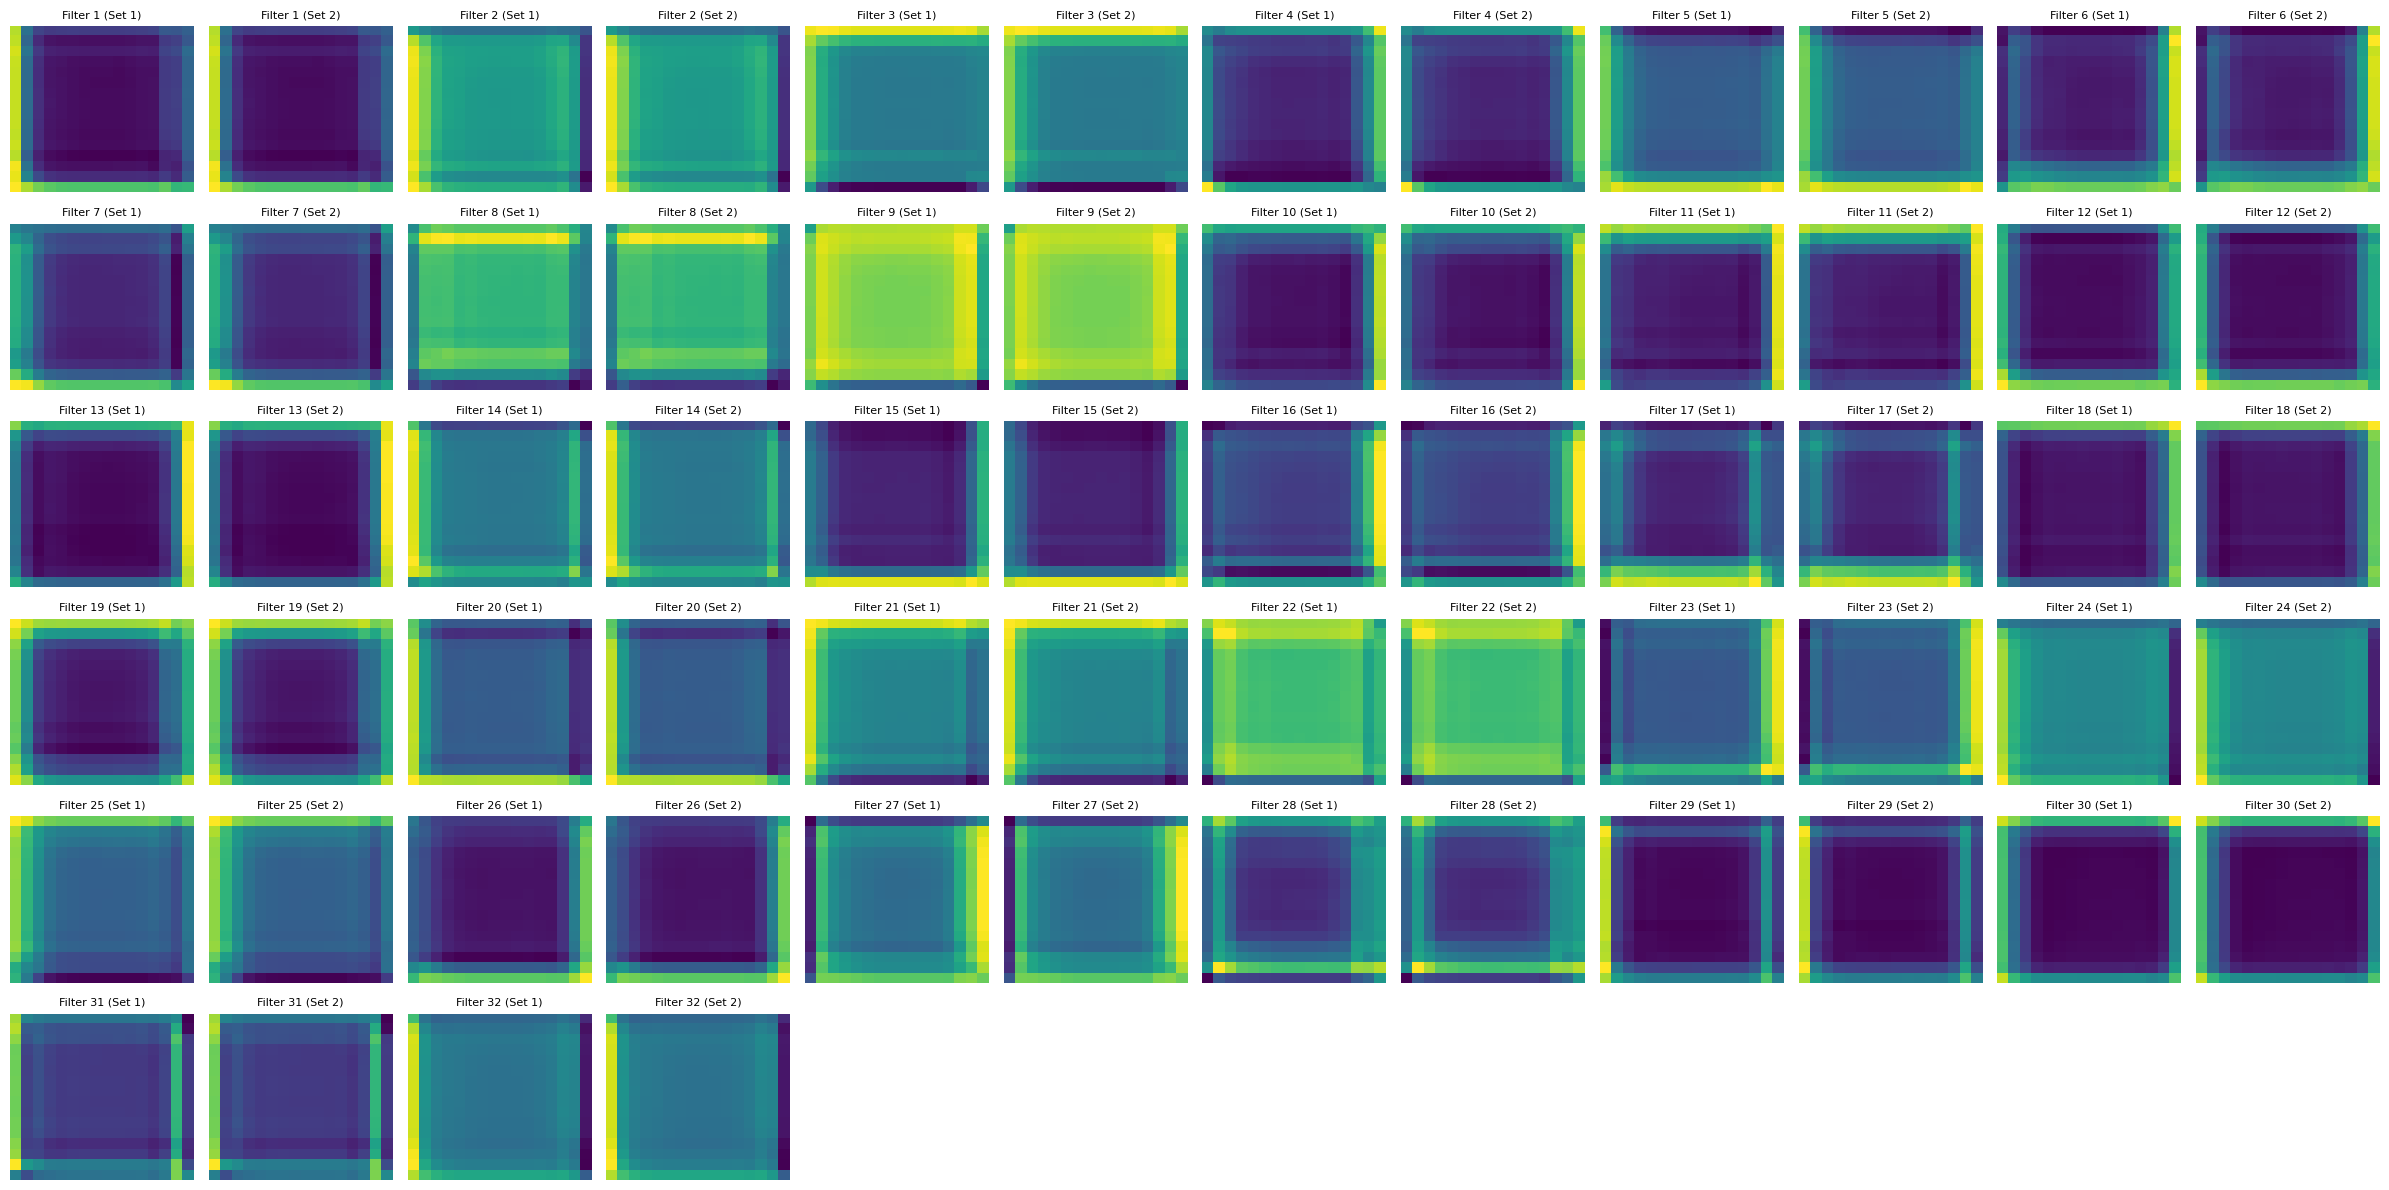

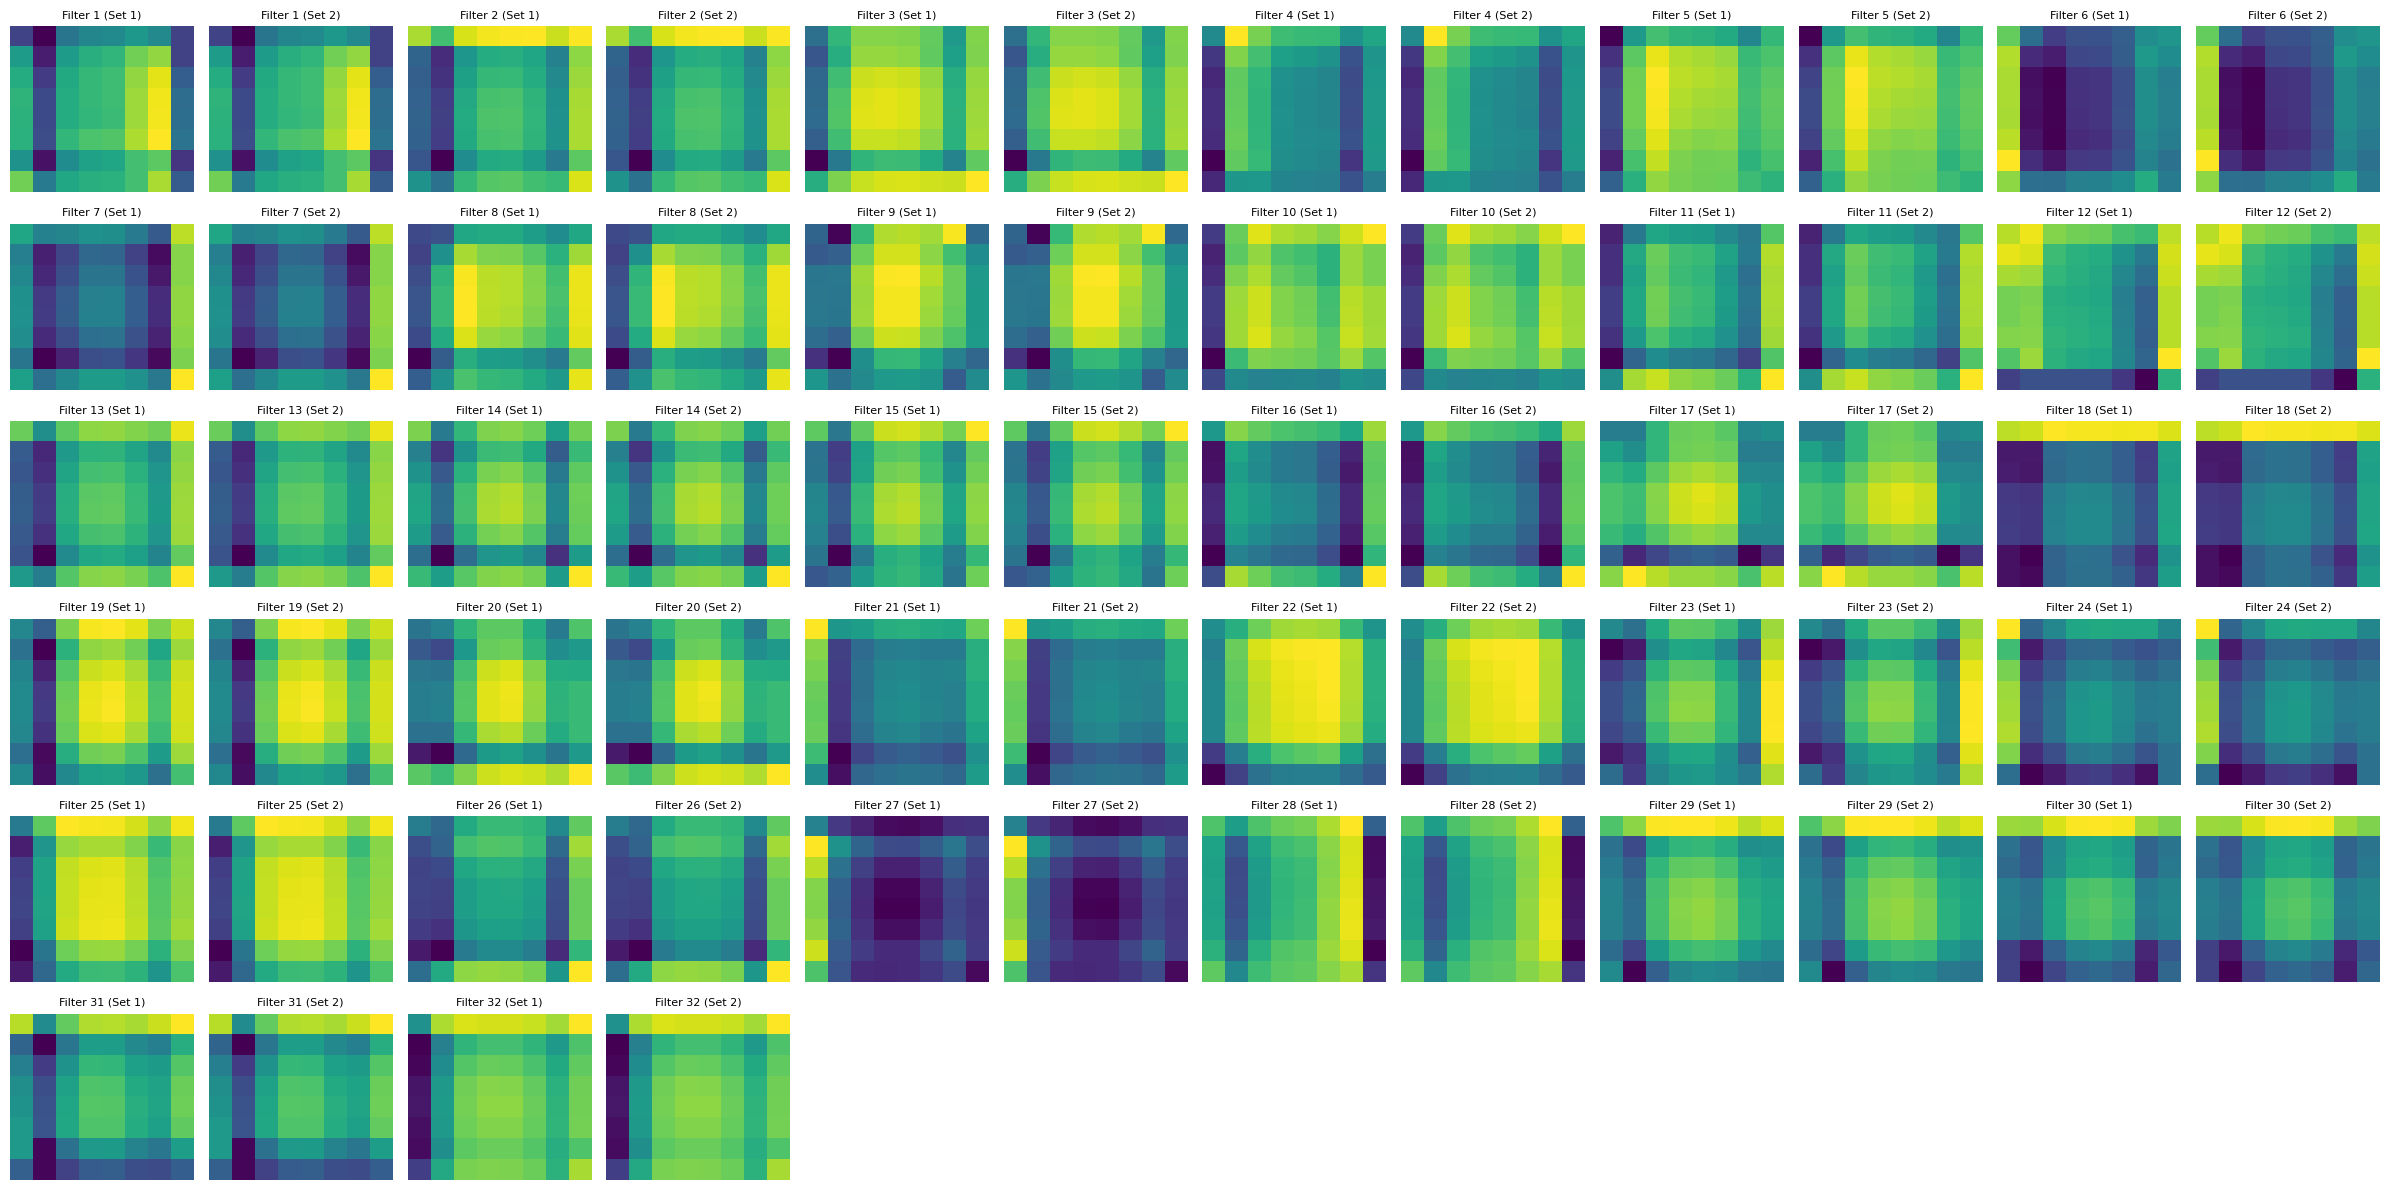

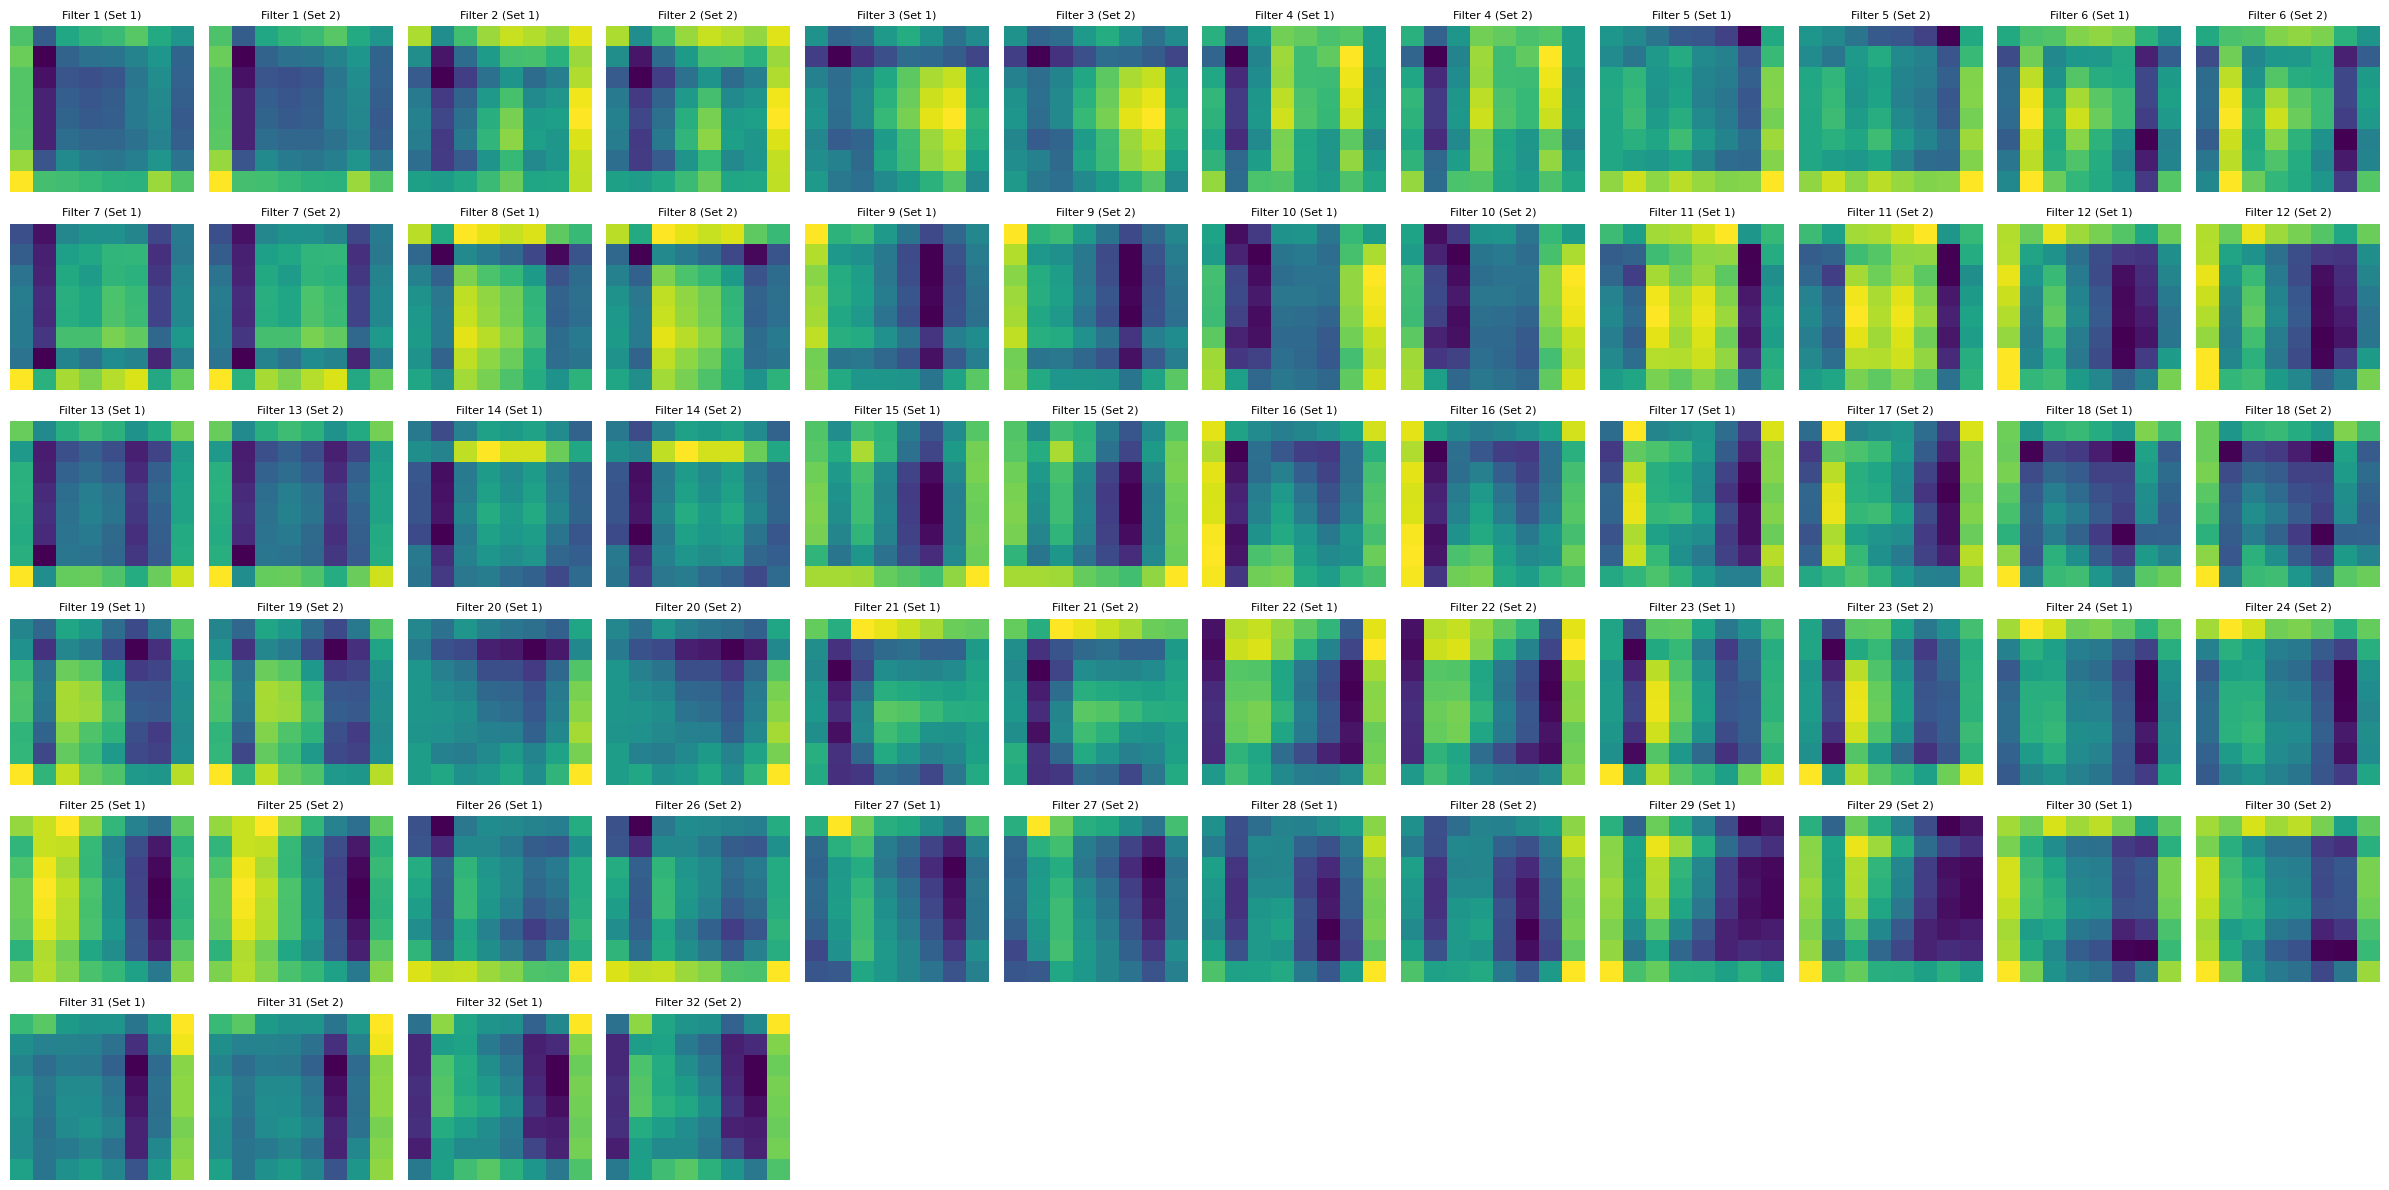

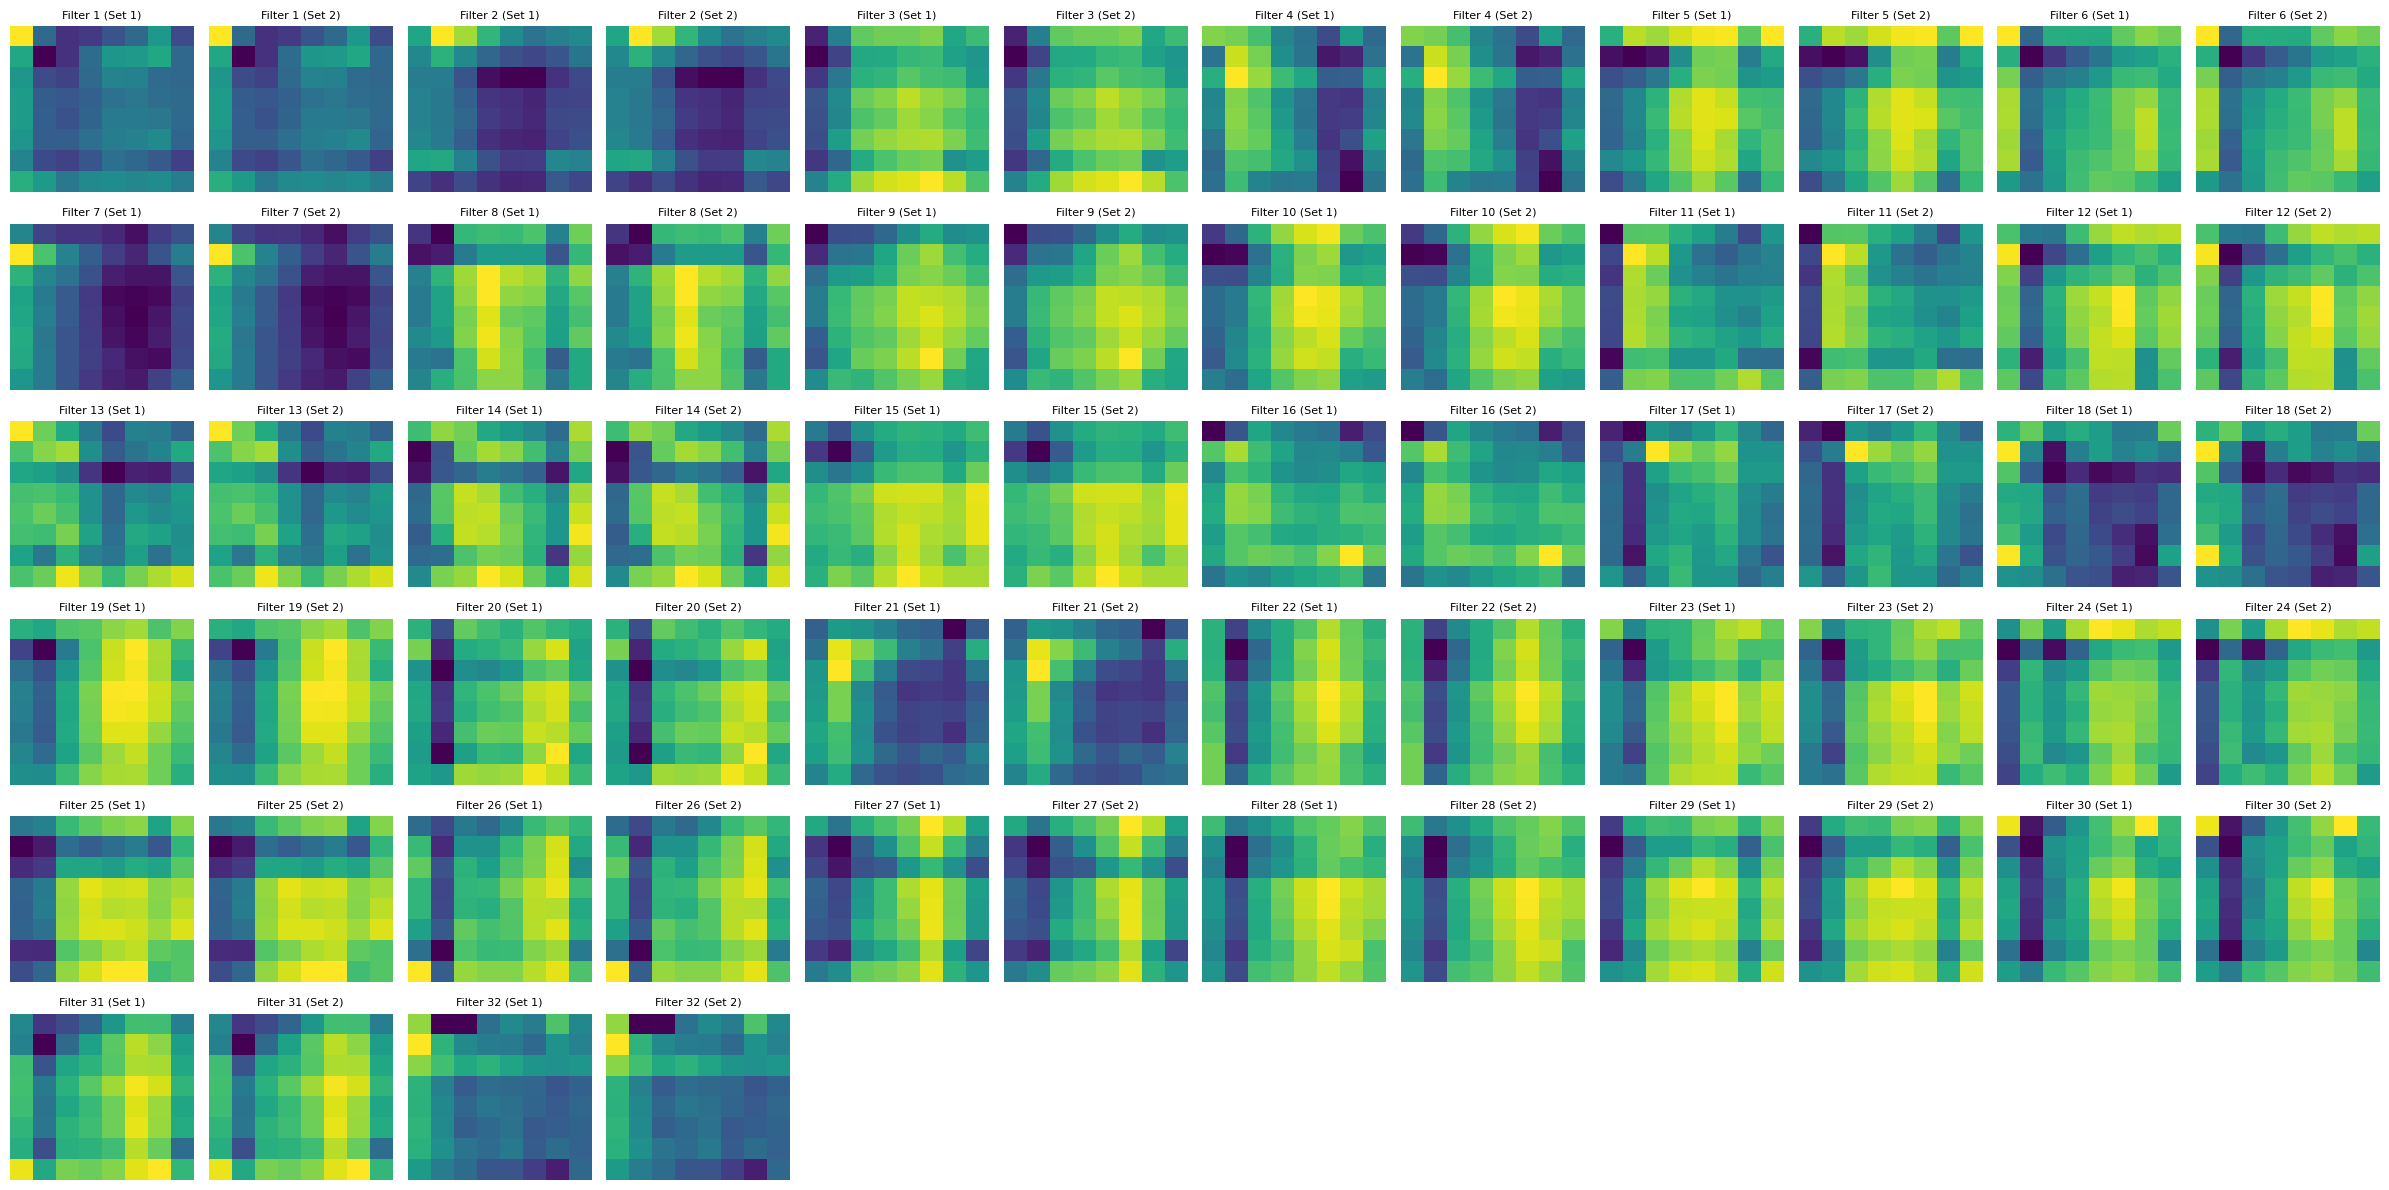

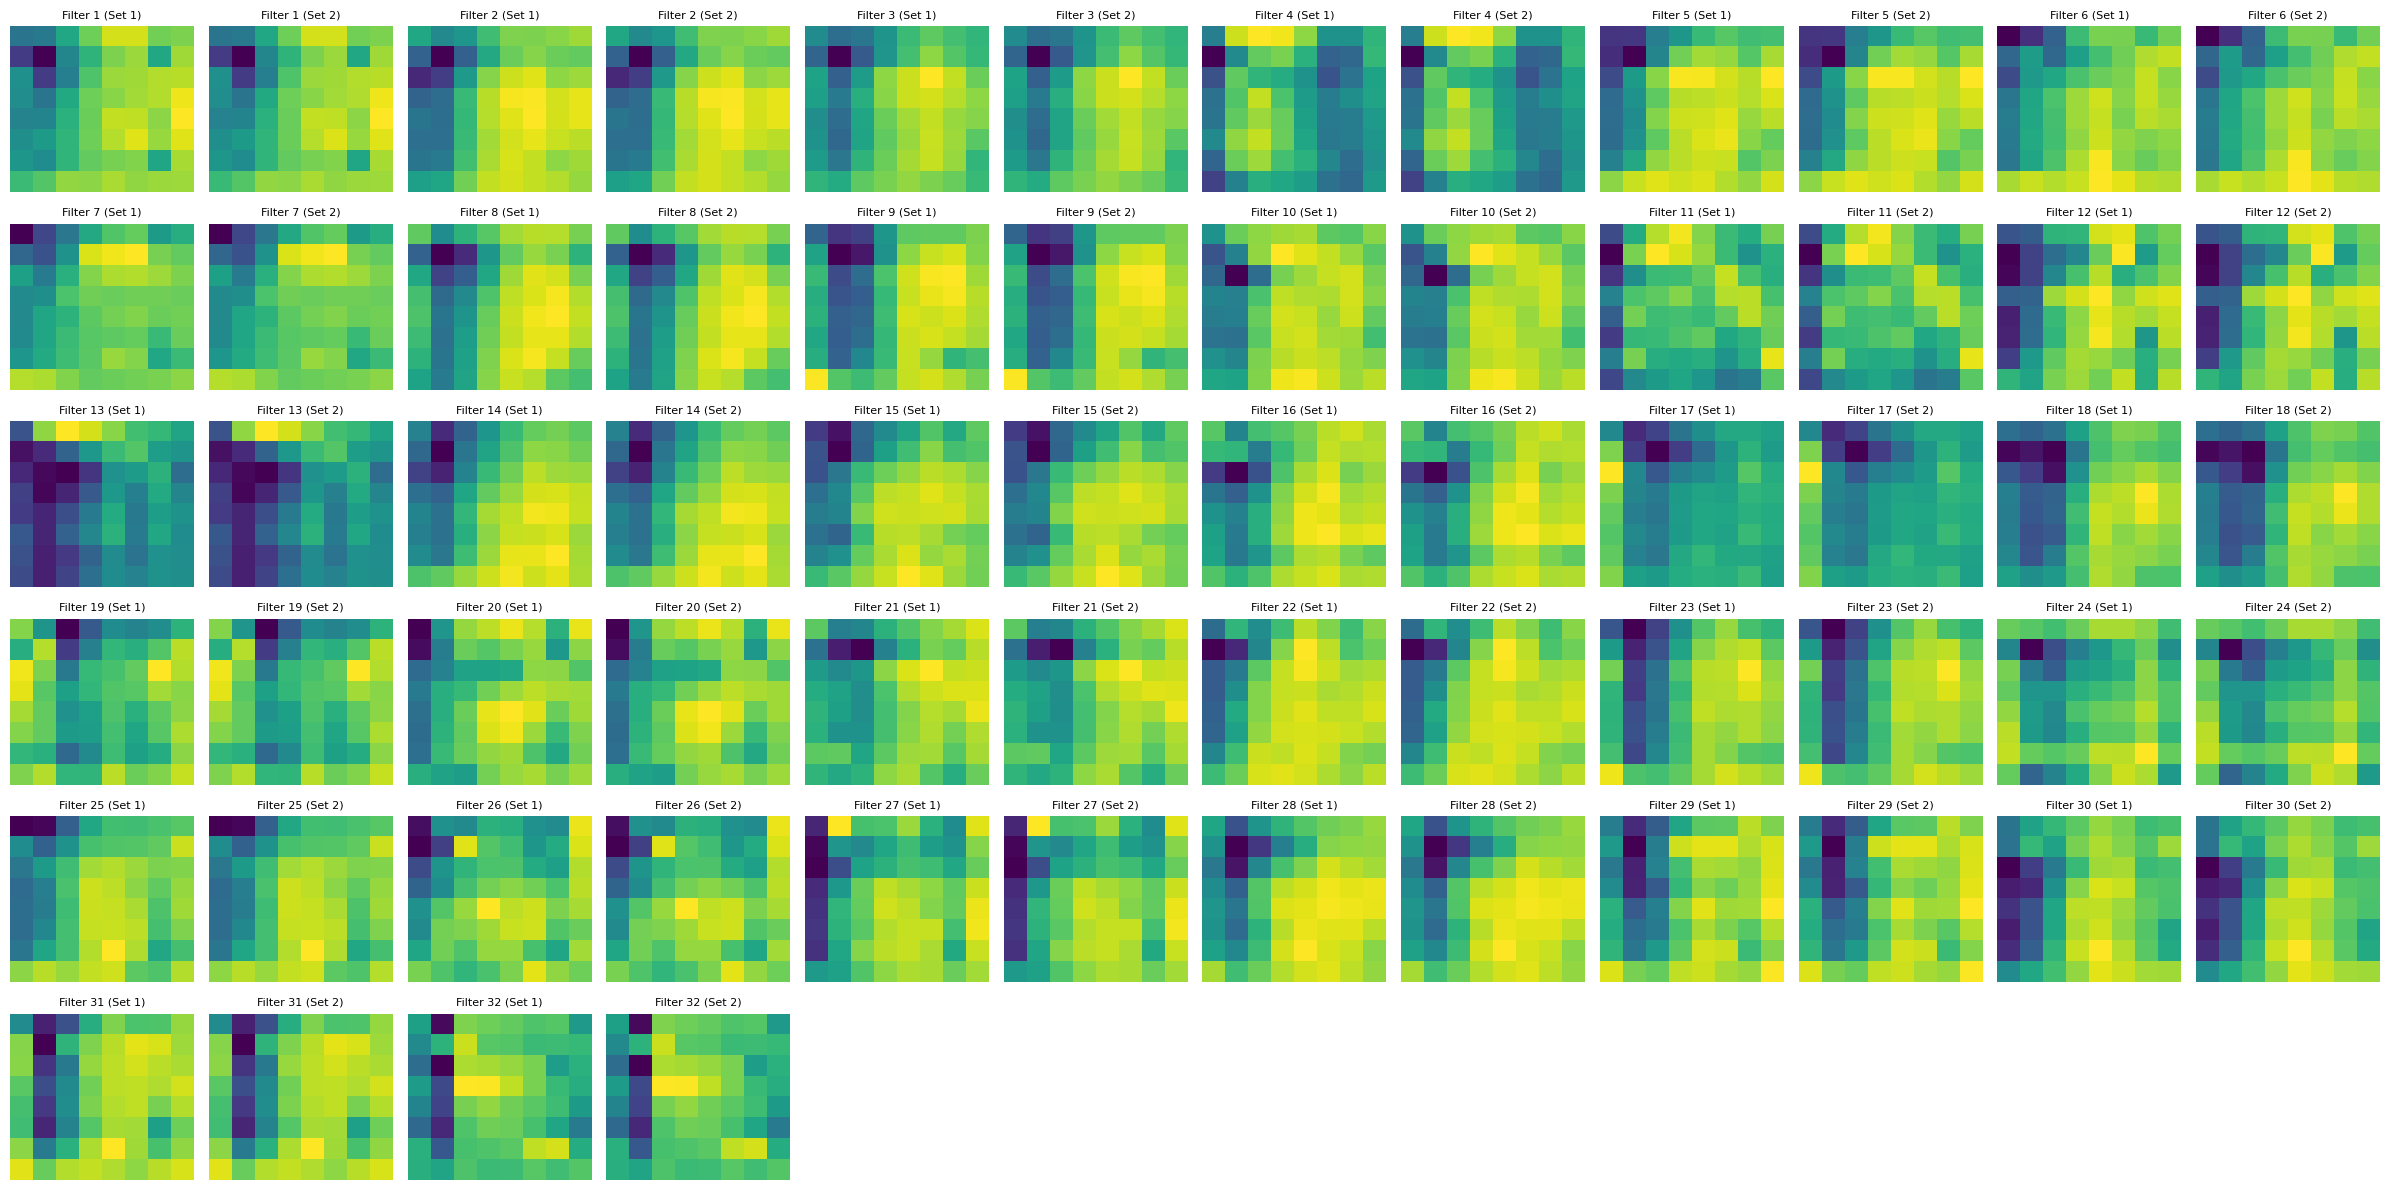

In [54]:
all_layers = ['conv_seqs_0_conv', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_1_conv', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1']
later_layers=[    
   'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1']

helpers.plot_activations_for_layers_side_by_side(blue_and_green_key_activations,blue_key_only_activations, all_layers)

In [44]:
blue_key_only_activations['conv_seqs_2_res_block0_conv1'][0].shape


torch.Size([32, 8, 8])

In [38]:
differences




{'conv_seqs_0_conv': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0.

In [60]:
helpers.plot_activations_for_layers(blue_key_only[0], layer_paths)

No activations found for layer: conv_seqs_0_conv
No activations found for layer: conv_seqs_0_res_block0_conv0
No activations found for layer: conv_seqs_0_res_block0_conv1
No activations found for layer: conv_seqs_0_res_block1_conv0
No activations found for layer: conv_seqs_0_res_block1_conv1
No activations found for layer: conv_seqs_1_conv
No activations found for layer: conv_seqs_1_res_block0_conv0
No activations found for layer: conv_seqs_1_res_block0_conv1
No activations found for layer: conv_seqs_1_res_block1_conv0
No activations found for layer: conv_seqs_1_res_block1_conv1
No activations found for layer: conv_seqs_2_conv
No activations found for layer: conv_seqs_2_res_block0_conv0
No activations found for layer: conv_seqs_2_res_block0_conv1
No activations found for layer: conv_seqs_2_res_block1_conv0
No activations found for layer: conv_seqs_2_res_block1_conv1
